# patch_size를 1, 3, 5, 7, 9, 11로 바꾸어 가면서 테스트 해 보자

In [1]:
from utils.utils import train_model, evaluate_model_with_cm, TiffDataset
from models.image_classifier import ResNetLike
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
import torch.nn as nn
import torch.optim as optim
import os
import pandas as pd

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
test_filter = lambda box_number: (box_number % 9 == 0 or box_number % 9 == 5)

### 데이터 준비함수, 학습 평가 함수 정의

In [4]:
# 이미지 전처리 (Naive)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.float()),  # uint16 → float 변환
])

# 데이터셋 생성 함수
def create_datasets(patch_size):
    dataset_kwargs = {
        "large_tif_dir": "../../data/source_data/naive",
        "file_list": ["jiri_1.tif", "jiri_2.tif", "sobaek.tif"],
        "label_file": "../../data/label_data/label_mapping_sampled.csv",
        "patch_size": patch_size,
        "transform": transform
    }
    return (
        TiffDataset(**dataset_kwargs, box_filter_fn=lambda box_number: not test_filter(box_number)),  # train
        TiffDataset(**dataset_kwargs, box_filter_fn=test_filter)  # val
    )

# 데이터로더 생성 함수
def create_dataloaders(train_dataset, val_dataset, batch_size=32, num_workers=0):
    return (
        DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers),
        DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    )


### 패치사이즈를 바꾸어가며 테스트

1
Training with patch size: 1


Epoch 1/50 - Validation: 100%|██████████| 1163/1163 [00:04<00:00, 249.51it/s]



Epoch [1/50], Train Loss: 0.5381, Train Accuracy: 79.85%, Val Loss: 0.6360, Val Accuracy: 74.70%



Epoch 2/50 - Validation: 100%|██████████| 1163/1163 [00:04<00:00, 252.50it/s]



Epoch [2/50], Train Loss: 0.4478, Train Accuracy: 83.31%, Val Loss: 0.5765, Val Accuracy: 79.57%



Epoch 3/50 - Validation: 100%|██████████| 1163/1163 [00:04<00:00, 248.24it/s]



Epoch [3/50], Train Loss: 0.4181, Train Accuracy: 84.39%, Val Loss: 0.6150, Val Accuracy: 76.10%



Epoch 4/50 - Validation: 100%|██████████| 1163/1163 [00:04<00:00, 251.95it/s]



Epoch [4/50], Train Loss: 0.3930, Train Accuracy: 85.33%, Val Loss: 0.5380, Val Accuracy: 82.21%



Epoch 5/50 - Validation: 100%|██████████| 1163/1163 [00:04<00:00, 250.15it/s]



Epoch [5/50], Train Loss: 0.3759, Train Accuracy: 86.07%, Val Loss: 0.4920, Val Accuracy: 83.41%



Epoch 6/50 - Validation: 100%|██████████| 1163/1163 [00:04<00:00, 248.19it/s]



Epoch [6/50], Train Loss: 0.3635, Train Accuracy: 86.44%, Val Loss: 0.5232, Val Accuracy: 82.01%



Epoch 7/50 - Validation: 100%|██████████| 1163/1163 [00:04<00:00, 250.86it/s]



Epoch [7/50], Train Loss: 0.3542, Train Accuracy: 86.86%, Val Loss: 0.5225, Val Accuracy: 81.72%



Epoch 8/50 - Validation: 100%|██████████| 1163/1163 [00:04<00:00, 250.70it/s]



Epoch [8/50], Train Loss: 0.3454, Train Accuracy: 87.18%, Val Loss: 0.4740, Val Accuracy: 84.67%



Epoch 9/50 - Validation: 100%|██████████| 1163/1163 [00:04<00:00, 255.74it/s]



Epoch [9/50], Train Loss: 0.3352, Train Accuracy: 87.51%, Val Loss: 0.5365, Val Accuracy: 82.23%



Epoch 10/50 - Validation: 100%|██████████| 1163/1163 [00:04<00:00, 256.96it/s]



Epoch [10/50], Train Loss: 0.3315, Train Accuracy: 87.73%, Val Loss: 0.5537, Val Accuracy: 81.69%



Epoch 11/50 - Validation: 100%|██████████| 1163/1163 [00:04<00:00, 254.91it/s]



Epoch [11/50], Train Loss: 0.3267, Train Accuracy: 87.95%, Val Loss: 0.5174, Val Accuracy: 82.35%



Epoch 12/50 - Validation: 100%|██████████| 1163/1163 [00:04<00:00, 252.01it/s]



Epoch [12/50], Train Loss: 0.3188, Train Accuracy: 88.29%, Val Loss: 0.5550, Val Accuracy: 80.28%



Epoch 13/50 - Validation: 100%|██████████| 1163/1163 [00:04<00:00, 255.22it/s]



Epoch [13/50], Train Loss: 0.3156, Train Accuracy: 88.31%, Val Loss: 0.5761, Val Accuracy: 78.30%



Epoch 14/50 - Validation: 100%|██████████| 1163/1163 [00:04<00:00, 255.10it/s]



Epoch [14/50], Train Loss: 0.3107, Train Accuracy: 88.59%, Val Loss: 0.5017, Val Accuracy: 84.17%



Epoch 15/50 - Validation: 100%|██████████| 1163/1163 [00:04<00:00, 255.09it/s]



Epoch [15/50], Train Loss: 0.3059, Train Accuracy: 88.72%, Val Loss: 0.5269, Val Accuracy: 82.88%



Epoch 16/50 - Validation: 100%|██████████| 1163/1163 [00:04<00:00, 255.54it/s]



Epoch [16/50], Train Loss: 0.3025, Train Accuracy: 88.77%, Val Loss: 0.5225, Val Accuracy: 83.66%



Epoch 17/50 - Validation: 100%|██████████| 1163/1163 [00:04<00:00, 255.96it/s]



Epoch [17/50], Train Loss: 0.2962, Train Accuracy: 89.12%, Val Loss: 0.5442, Val Accuracy: 80.91%



Epoch 18/50 - Validation: 100%|██████████| 1163/1163 [00:04<00:00, 256.44it/s]



Epoch [18/50], Train Loss: 0.2941, Train Accuracy: 89.08%, Val Loss: 0.5237, Val Accuracy: 83.06%



Epoch 19/50 - Validation: 100%|██████████| 1163/1163 [00:04<00:00, 256.39it/s]



Epoch [19/50], Train Loss: 0.2911, Train Accuracy: 89.30%, Val Loss: 0.5111, Val Accuracy: 83.94%



Epoch 20/50 - Validation: 100%|██████████| 1163/1163 [00:04<00:00, 256.03it/s]



Epoch [20/50], Train Loss: 0.2885, Train Accuracy: 89.39%, Val Loss: 0.5410, Val Accuracy: 82.11%



Epoch 21/50 - Validation: 100%|██████████| 1163/1163 [00:04<00:00, 252.83it/s]



Epoch [21/50], Train Loss: 0.2859, Train Accuracy: 89.49%, Val Loss: 0.5609, Val Accuracy: 81.28%



Epoch 22/50 - Validation: 100%|██████████| 1163/1163 [00:04<00:00, 253.52it/s]



Epoch [22/50], Train Loss: 0.2846, Train Accuracy: 89.46%, Val Loss: 0.5524, Val Accuracy: 82.08%



Epoch 23/50 - Validation: 100%|██████████| 1163/1163 [00:04<00:00, 254.72it/s]



Epoch [23/50], Train Loss: 0.2822, Train Accuracy: 89.59%, Val Loss: 0.4828, Val Accuracy: 83.82%



Epoch 24/50 - Validation: 100%|██████████| 1163/1163 [00:04<00:00, 253.97it/s]



Epoch [24/50], Train Loss: 0.2780, Train Accuracy: 89.84%, Val Loss: 0.6005, Val Accuracy: 82.75%



Epoch 25/50 - Validation: 100%|██████████| 1163/1163 [00:04<00:00, 253.30it/s]



Epoch [25/50], Train Loss: 0.2755, Train Accuracy: 89.85%, Val Loss: 0.5369, Val Accuracy: 82.98%



Epoch 26/50 - Validation: 100%|██████████| 1163/1163 [00:04<00:00, 250.66it/s]



Epoch [26/50], Train Loss: 0.2719, Train Accuracy: 89.95%, Val Loss: 0.5585, Val Accuracy: 81.83%



Epoch 27/50 - Validation: 100%|██████████| 1163/1163 [00:04<00:00, 250.96it/s]



Epoch [27/50], Train Loss: 0.2702, Train Accuracy: 90.12%, Val Loss: 0.5231, Val Accuracy: 84.28%



Epoch 28/50 - Validation: 100%|██████████| 1163/1163 [00:04<00:00, 253.64it/s]



Epoch [28/50], Train Loss: 0.2676, Train Accuracy: 90.15%, Val Loss: 0.7252, Val Accuracy: 82.45%



Epoch 29/50 - Validation: 100%|██████████| 1163/1163 [00:04<00:00, 254.69it/s]



Epoch [29/50], Train Loss: 0.2681, Train Accuracy: 90.13%, Val Loss: 0.5961, Val Accuracy: 81.24%



Epoch 30/50 - Validation: 100%|██████████| 1163/1163 [00:04<00:00, 254.30it/s]



Epoch [30/50], Train Loss: 0.2656, Train Accuracy: 90.25%, Val Loss: 0.5255, Val Accuracy: 83.00%



Epoch 31/50 - Validation: 100%|██████████| 1163/1163 [00:04<00:00, 248.54it/s]



Epoch [31/50], Train Loss: 0.2631, Train Accuracy: 90.36%, Val Loss: 0.5044, Val Accuracy: 83.75%



Epoch 32/50 - Validation: 100%|██████████| 1163/1163 [00:04<00:00, 250.74it/s]



Epoch [32/50], Train Loss: 0.2633, Train Accuracy: 90.27%, Val Loss: 0.6083, Val Accuracy: 79.14%



Epoch 33/50 - Validation: 100%|██████████| 1163/1163 [00:04<00:00, 250.91it/s]



Epoch [33/50], Train Loss: 0.2618, Train Accuracy: 90.35%, Val Loss: 0.5485, Val Accuracy: 82.50%



Epoch 34/50 - Validation: 100%|██████████| 1163/1163 [00:04<00:00, 250.53it/s]



Epoch [34/50], Train Loss: 0.2573, Train Accuracy: 90.50%, Val Loss: 0.6925, Val Accuracy: 83.08%



Epoch 35/50 - Validation: 100%|██████████| 1163/1163 [00:04<00:00, 249.07it/s]



Epoch [35/50], Train Loss: 0.2577, Train Accuracy: 90.52%, Val Loss: 0.4869, Val Accuracy: 84.92%



Epoch 36/50 - Validation: 100%|██████████| 1163/1163 [00:04<00:00, 254.21it/s]



Epoch [36/50], Train Loss: 0.2552, Train Accuracy: 90.64%, Val Loss: 0.5634, Val Accuracy: 82.47%



Epoch 37/50 - Validation: 100%|██████████| 1163/1163 [00:04<00:00, 251.68it/s]



Epoch [37/50], Train Loss: 0.2535, Train Accuracy: 90.66%, Val Loss: 0.5226, Val Accuracy: 83.60%



Epoch 38/50 - Validation: 100%|██████████| 1163/1163 [00:04<00:00, 253.16it/s]



Epoch [38/50], Train Loss: 0.2525, Train Accuracy: 90.66%, Val Loss: 0.5016, Val Accuracy: 83.12%



Epoch 39/50 - Validation: 100%|██████████| 1163/1163 [00:04<00:00, 254.14it/s]



Epoch [39/50], Train Loss: 0.2511, Train Accuracy: 90.70%, Val Loss: 0.5341, Val Accuracy: 82.44%



Epoch 40/50 - Validation: 100%|██████████| 1163/1163 [00:04<00:00, 252.44it/s]



Epoch [40/50], Train Loss: 0.2493, Train Accuracy: 90.87%, Val Loss: 0.5793, Val Accuracy: 79.23%



Epoch 41/50 - Validation: 100%|██████████| 1163/1163 [00:04<00:00, 253.91it/s]



Epoch [41/50], Train Loss: 0.2502, Train Accuracy: 90.79%, Val Loss: 0.5999, Val Accuracy: 81.09%



Epoch 42/50 - Validation: 100%|██████████| 1163/1163 [00:04<00:00, 253.57it/s]



Epoch [42/50], Train Loss: 0.2503, Train Accuracy: 90.75%, Val Loss: 0.5612, Val Accuracy: 83.62%



Epoch 43/50 - Validation: 100%|██████████| 1163/1163 [00:04<00:00, 250.41it/s]



Epoch [43/50], Train Loss: 0.2458, Train Accuracy: 90.99%, Val Loss: 0.5411, Val Accuracy: 83.08%



Epoch 44/50 - Validation: 100%|██████████| 1163/1163 [00:04<00:00, 253.63it/s]



Epoch [44/50], Train Loss: 0.2463, Train Accuracy: 90.98%, Val Loss: 0.6191, Val Accuracy: 80.72%



Epoch 45/50 - Validation: 100%|██████████| 1163/1163 [00:04<00:00, 253.14it/s]



Epoch [45/50], Train Loss: 0.2462, Train Accuracy: 90.91%, Val Loss: 0.5838, Val Accuracy: 81.99%



Epoch 46/50 - Validation: 100%|██████████| 1163/1163 [00:04<00:00, 252.69it/s]



Epoch [46/50], Train Loss: 0.2440, Train Accuracy: 91.02%, Val Loss: 0.5722, Val Accuracy: 81.39%



Epoch 47/50 - Validation: 100%|██████████| 1163/1163 [00:04<00:00, 253.61it/s]



Epoch [47/50], Train Loss: 0.2419, Train Accuracy: 91.13%, Val Loss: 0.6166, Val Accuracy: 79.03%



Epoch 48/50 - Validation: 100%|██████████| 1163/1163 [00:04<00:00, 253.92it/s]



Epoch [48/50], Train Loss: 0.2410, Train Accuracy: 91.11%, Val Loss: 0.6021, Val Accuracy: 79.06%



Epoch 49/50 - Validation: 100%|██████████| 1163/1163 [00:04<00:00, 253.44it/s]



Epoch [49/50], Train Loss: 0.2424, Train Accuracy: 91.14%, Val Loss: 0.5377, Val Accuracy: 82.73%



Epoch 50/50 - Validation: 100%|██████████| 1163/1163 [00:04<00:00, 253.91it/s]



Epoch [50/50], Train Loss: 0.2398, Train Accuracy: 91.17%, Val Loss: 0.6353, Val Accuracy: 81.56%

train data


Evaluation Progress: 100%|██████████| 3683/3683 [00:14<00:00, 252.60it/s]


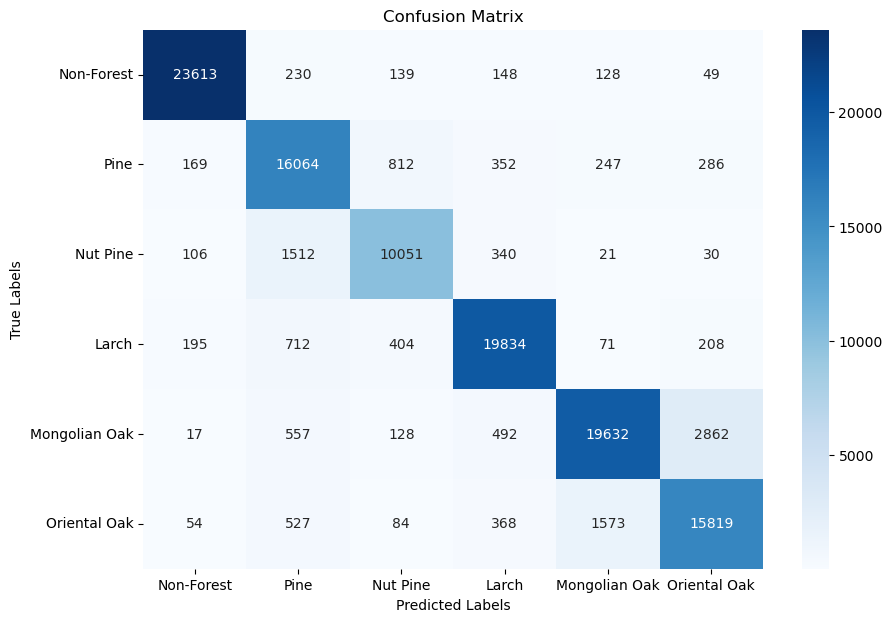

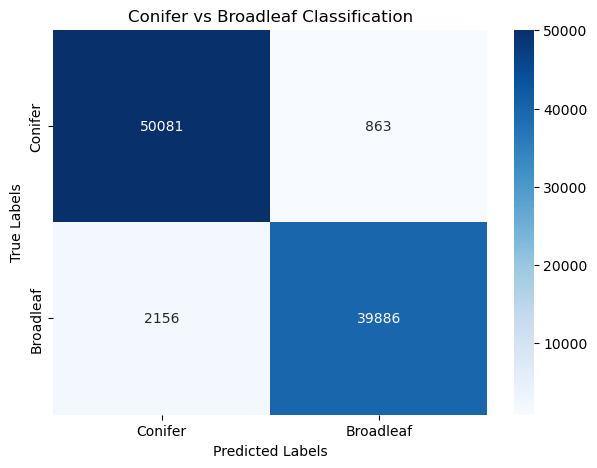

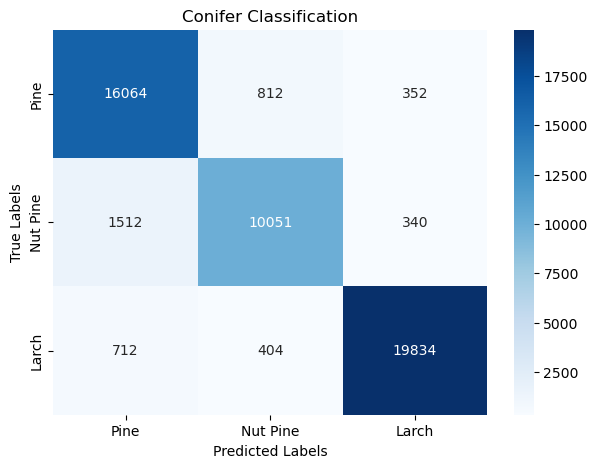

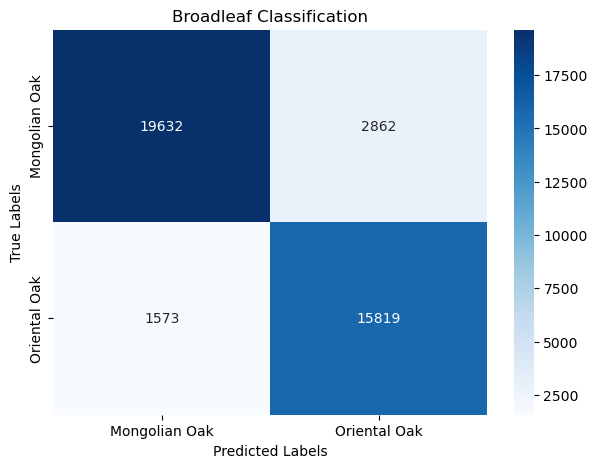

validation data


Evaluation Progress: 100%|██████████| 1163/1163 [00:04<00:00, 253.30it/s]


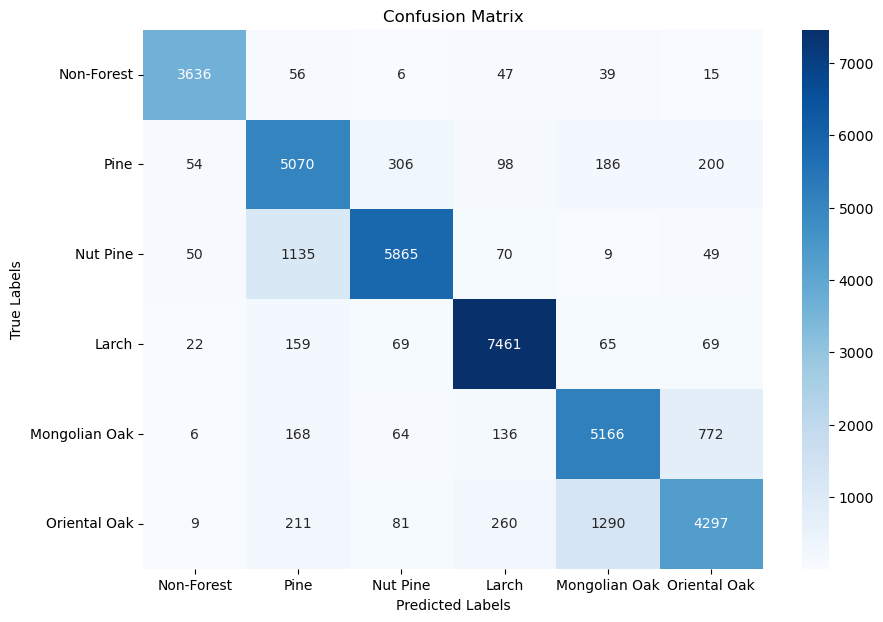

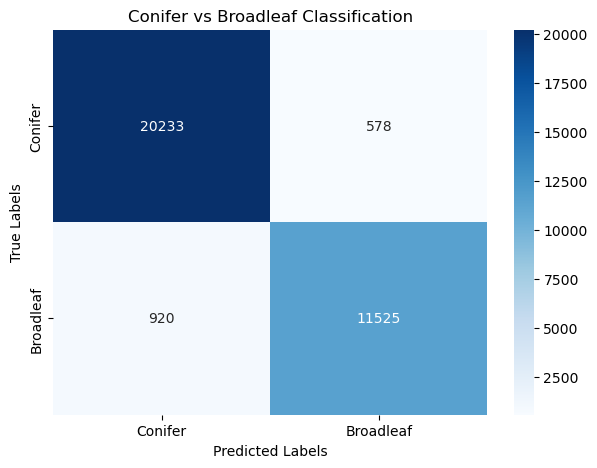

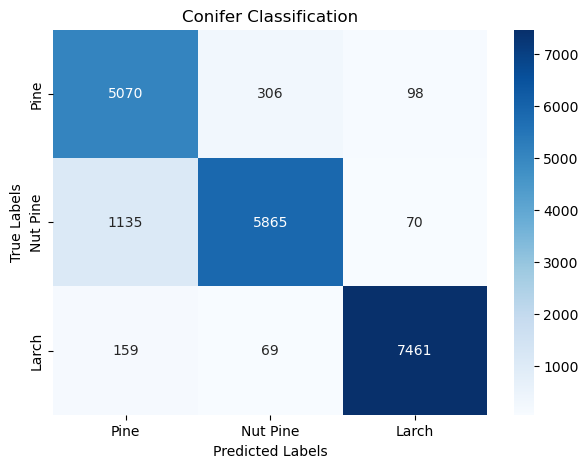

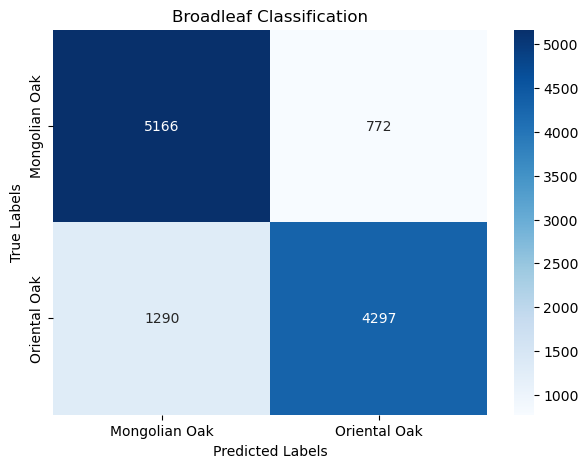

3
Training with patch size: 3


Epoch 1/50 - Validation: 100%|██████████| 1163/1163 [00:05<00:00, 230.17it/s]



Epoch [1/50], Train Loss: 0.5061, Train Accuracy: 81.15%, Val Loss: 0.4788, Val Accuracy: 82.98%



Epoch 2/50 - Validation: 100%|██████████| 1163/1163 [00:05<00:00, 230.45it/s]



Epoch [2/50], Train Loss: 0.4071, Train Accuracy: 84.81%, Val Loss: 0.5310, Val Accuracy: 82.40%



Epoch 3/50 - Validation: 100%|██████████| 1163/1163 [00:05<00:00, 231.03it/s]



Epoch [3/50], Train Loss: 0.3682, Train Accuracy: 86.38%, Val Loss: 0.5285, Val Accuracy: 82.29%



Epoch 4/50 - Validation: 100%|██████████| 1163/1163 [00:05<00:00, 231.56it/s]



Epoch [4/50], Train Loss: 0.3407, Train Accuracy: 87.49%, Val Loss: 0.4692, Val Accuracy: 85.16%



Epoch 5/50 - Validation: 100%|██████████| 1163/1163 [00:05<00:00, 229.85it/s]



Epoch [5/50], Train Loss: 0.3213, Train Accuracy: 88.22%, Val Loss: 0.6142, Val Accuracy: 77.69%



Epoch 6/50 - Validation: 100%|██████████| 1163/1163 [00:05<00:00, 228.92it/s]



Epoch [6/50], Train Loss: 0.3080, Train Accuracy: 88.70%, Val Loss: 0.5547, Val Accuracy: 81.53%



Epoch 7/50 - Validation: 100%|██████████| 1163/1163 [00:05<00:00, 228.67it/s]



Epoch [7/50], Train Loss: 0.2966, Train Accuracy: 89.14%, Val Loss: 0.5164, Val Accuracy: 83.26%



Epoch 8/50 - Validation: 100%|██████████| 1163/1163 [00:05<00:00, 229.46it/s]



Epoch [8/50], Train Loss: 0.2876, Train Accuracy: 89.44%, Val Loss: 0.4992, Val Accuracy: 84.50%



Epoch 9/50 - Validation: 100%|██████████| 1163/1163 [00:05<00:00, 231.93it/s]



Epoch [9/50], Train Loss: 0.2777, Train Accuracy: 89.77%, Val Loss: 0.5052, Val Accuracy: 83.98%



Epoch 10/50 - Validation: 100%|██████████| 1163/1163 [00:05<00:00, 231.41it/s]



Epoch [10/50], Train Loss: 0.2690, Train Accuracy: 90.14%, Val Loss: 0.5089, Val Accuracy: 82.75%



Epoch 11/50 - Validation: 100%|██████████| 1163/1163 [00:05<00:00, 228.27it/s]



Epoch [11/50], Train Loss: 0.2637, Train Accuracy: 90.37%, Val Loss: 0.5297, Val Accuracy: 83.75%



Epoch 12/50 - Validation: 100%|██████████| 1163/1163 [00:05<00:00, 231.53it/s]



Epoch [12/50], Train Loss: 0.2570, Train Accuracy: 90.60%, Val Loss: 0.5212, Val Accuracy: 84.77%



Epoch 13/50 - Validation: 100%|██████████| 1163/1163 [00:05<00:00, 228.98it/s]



Epoch [13/50], Train Loss: 0.2518, Train Accuracy: 90.75%, Val Loss: 0.5546, Val Accuracy: 82.16%



Epoch 14/50 - Validation: 100%|██████████| 1163/1163 [00:05<00:00, 228.14it/s]



Epoch [14/50], Train Loss: 0.2513, Train Accuracy: 90.82%, Val Loss: 0.4777, Val Accuracy: 85.46%



Epoch 15/50 - Validation: 100%|██████████| 1163/1163 [00:05<00:00, 231.82it/s]



Epoch [15/50], Train Loss: 0.2434, Train Accuracy: 91.12%, Val Loss: 0.4909, Val Accuracy: 84.96%



Epoch 16/50 - Validation: 100%|██████████| 1163/1163 [00:05<00:00, 229.78it/s]



Epoch [16/50], Train Loss: 0.2405, Train Accuracy: 91.15%, Val Loss: 0.5719, Val Accuracy: 82.12%



Epoch 17/50 - Validation: 100%|██████████| 1163/1163 [00:05<00:00, 229.36it/s]



Epoch [17/50], Train Loss: 0.2362, Train Accuracy: 91.35%, Val Loss: 0.4893, Val Accuracy: 85.83%



Epoch 18/50 - Validation: 100%|██████████| 1163/1163 [00:05<00:00, 231.80it/s]



Epoch [18/50], Train Loss: 0.2330, Train Accuracy: 91.49%, Val Loss: 0.5495, Val Accuracy: 83.77%



Epoch 19/50 - Validation: 100%|██████████| 1163/1163 [00:05<00:00, 228.30it/s]



Epoch [19/50], Train Loss: 0.2285, Train Accuracy: 91.56%, Val Loss: 0.5443, Val Accuracy: 83.91%



Epoch 20/50 - Validation: 100%|██████████| 1163/1163 [00:05<00:00, 229.56it/s]



Epoch [20/50], Train Loss: 0.2269, Train Accuracy: 91.71%, Val Loss: 0.6071, Val Accuracy: 83.05%



Epoch 21/50 - Validation: 100%|██████████| 1163/1163 [00:05<00:00, 228.12it/s]



Epoch [21/50], Train Loss: 0.2237, Train Accuracy: 91.79%, Val Loss: 0.5578, Val Accuracy: 83.15%



Epoch 22/50 - Validation: 100%|██████████| 1163/1163 [00:05<00:00, 231.87it/s]



Epoch [22/50], Train Loss: 0.2201, Train Accuracy: 92.00%, Val Loss: 0.7201, Val Accuracy: 79.04%



Epoch 23/50 - Validation: 100%|██████████| 1163/1163 [00:05<00:00, 229.49it/s]



Epoch [23/50], Train Loss: 0.2167, Train Accuracy: 92.06%, Val Loss: 0.5272, Val Accuracy: 83.71%



Epoch 24/50 - Validation: 100%|██████████| 1163/1163 [00:05<00:00, 231.45it/s]



Epoch [24/50], Train Loss: 0.2143, Train Accuracy: 92.07%, Val Loss: 0.5135, Val Accuracy: 86.14%



Epoch 25/50 - Validation: 100%|██████████| 1163/1163 [00:05<00:00, 228.58it/s]



Epoch [25/50], Train Loss: 0.2122, Train Accuracy: 92.27%, Val Loss: 0.5559, Val Accuracy: 84.81%



Epoch 26/50 - Validation: 100%|██████████| 1163/1163 [00:05<00:00, 228.95it/s]



Epoch [26/50], Train Loss: 0.2088, Train Accuracy: 92.34%, Val Loss: 0.5522, Val Accuracy: 84.21%



Epoch 27/50 - Validation: 100%|██████████| 1163/1163 [00:05<00:00, 232.00it/s]



Epoch [27/50], Train Loss: 0.2074, Train Accuracy: 92.45%, Val Loss: 0.5858, Val Accuracy: 84.41%



Epoch 28/50 - Validation: 100%|██████████| 1163/1163 [00:05<00:00, 231.98it/s]



Epoch [28/50], Train Loss: 0.2053, Train Accuracy: 92.37%, Val Loss: 0.5780, Val Accuracy: 83.70%



Epoch 29/50 - Validation: 100%|██████████| 1163/1163 [00:05<00:00, 231.82it/s]



Epoch [29/50], Train Loss: 0.2021, Train Accuracy: 92.57%, Val Loss: 0.5474, Val Accuracy: 83.99%



Epoch 30/50 - Validation: 100%|██████████| 1163/1163 [00:05<00:00, 231.79it/s]



Epoch [30/50], Train Loss: 0.2022, Train Accuracy: 92.57%, Val Loss: 0.5684, Val Accuracy: 83.54%



Epoch 31/50 - Validation: 100%|██████████| 1163/1163 [00:05<00:00, 228.77it/s]



Epoch [31/50], Train Loss: 0.2012, Train Accuracy: 92.62%, Val Loss: 0.5161, Val Accuracy: 85.50%



Epoch 32/50 - Validation: 100%|██████████| 1163/1163 [00:05<00:00, 229.59it/s]



Epoch [32/50], Train Loss: 0.1994, Train Accuracy: 92.66%, Val Loss: 0.5925, Val Accuracy: 83.96%



Epoch 33/50 - Validation: 100%|██████████| 1163/1163 [00:05<00:00, 231.42it/s]



Epoch [33/50], Train Loss: 0.1971, Train Accuracy: 92.78%, Val Loss: 0.6023, Val Accuracy: 81.86%



Epoch 34/50 - Validation: 100%|██████████| 1163/1163 [00:05<00:00, 231.25it/s]



Epoch [34/50], Train Loss: 0.1960, Train Accuracy: 92.81%, Val Loss: 0.5701, Val Accuracy: 84.26%



Epoch 35/50 - Validation: 100%|██████████| 1163/1163 [00:05<00:00, 231.61it/s]



Epoch [35/50], Train Loss: 0.1939, Train Accuracy: 92.96%, Val Loss: 0.5461, Val Accuracy: 84.30%



Epoch 36/50 - Validation: 100%|██████████| 1163/1163 [00:05<00:00, 232.31it/s]



Epoch [36/50], Train Loss: 0.1914, Train Accuracy: 93.04%, Val Loss: 0.5317, Val Accuracy: 84.39%



Epoch 37/50 - Validation: 100%|██████████| 1163/1163 [00:05<00:00, 231.64it/s]



Epoch [37/50], Train Loss: 0.1905, Train Accuracy: 93.06%, Val Loss: 0.5410, Val Accuracy: 85.13%



Epoch 38/50 - Validation: 100%|██████████| 1163/1163 [00:05<00:00, 231.86it/s]



Epoch [38/50], Train Loss: 0.1889, Train Accuracy: 92.99%, Val Loss: 0.5327, Val Accuracy: 84.56%



Epoch 39/50 - Validation: 100%|██████████| 1163/1163 [00:05<00:00, 229.11it/s]



Epoch [39/50], Train Loss: 0.1883, Train Accuracy: 93.08%, Val Loss: 0.5561, Val Accuracy: 84.67%



Epoch 40/50 - Validation: 100%|██████████| 1163/1163 [00:05<00:00, 231.83it/s]



Epoch [40/50], Train Loss: 0.1872, Train Accuracy: 93.15%, Val Loss: 0.5549, Val Accuracy: 84.23%



Epoch 41/50 - Validation: 100%|██████████| 1163/1163 [00:05<00:00, 229.17it/s]



Epoch [41/50], Train Loss: 0.1848, Train Accuracy: 93.25%, Val Loss: 0.5148, Val Accuracy: 85.87%



Epoch 42/50 - Validation: 100%|██████████| 1163/1163 [00:05<00:00, 228.66it/s]



Epoch [42/50], Train Loss: 0.1838, Train Accuracy: 93.26%, Val Loss: 0.5532, Val Accuracy: 85.75%



Epoch 43/50 - Validation: 100%|██████████| 1163/1163 [00:05<00:00, 230.15it/s]



Epoch [43/50], Train Loss: 0.1810, Train Accuracy: 93.33%, Val Loss: 0.5417, Val Accuracy: 85.77%



Epoch 44/50 - Validation: 100%|██████████| 1163/1163 [00:05<00:00, 231.33it/s]



Epoch [44/50], Train Loss: 0.1817, Train Accuracy: 93.36%, Val Loss: 0.5938, Val Accuracy: 82.83%



Epoch 45/50 - Validation: 100%|██████████| 1163/1163 [00:05<00:00, 227.78it/s]



Epoch [45/50], Train Loss: 0.1795, Train Accuracy: 93.36%, Val Loss: 0.5178, Val Accuracy: 85.33%



Epoch 46/50 - Validation: 100%|██████████| 1163/1163 [00:05<00:00, 231.52it/s]



Epoch [46/50], Train Loss: 0.1790, Train Accuracy: 93.37%, Val Loss: 0.5773, Val Accuracy: 83.22%



Epoch 47/50 - Validation: 100%|██████████| 1163/1163 [00:05<00:00, 229.83it/s]



Epoch [47/50], Train Loss: 0.1773, Train Accuracy: 93.46%, Val Loss: 0.5060, Val Accuracy: 86.46%



Epoch 48/50 - Validation: 100%|██████████| 1163/1163 [00:05<00:00, 231.36it/s]



Epoch [48/50], Train Loss: 0.1772, Train Accuracy: 93.47%, Val Loss: 0.5496, Val Accuracy: 84.72%



Epoch 49/50 - Validation: 100%|██████████| 1163/1163 [00:05<00:00, 231.48it/s]



Epoch [49/50], Train Loss: 0.1758, Train Accuracy: 93.56%, Val Loss: 0.5926, Val Accuracy: 84.34%



Epoch 50/50 - Validation: 100%|██████████| 1163/1163 [00:05<00:00, 231.99it/s]



Epoch [50/50], Train Loss: 0.1753, Train Accuracy: 93.58%, Val Loss: 0.5319, Val Accuracy: 85.21%

train data


Evaluation Progress: 100%|██████████| 3683/3683 [00:15<00:00, 230.52it/s]


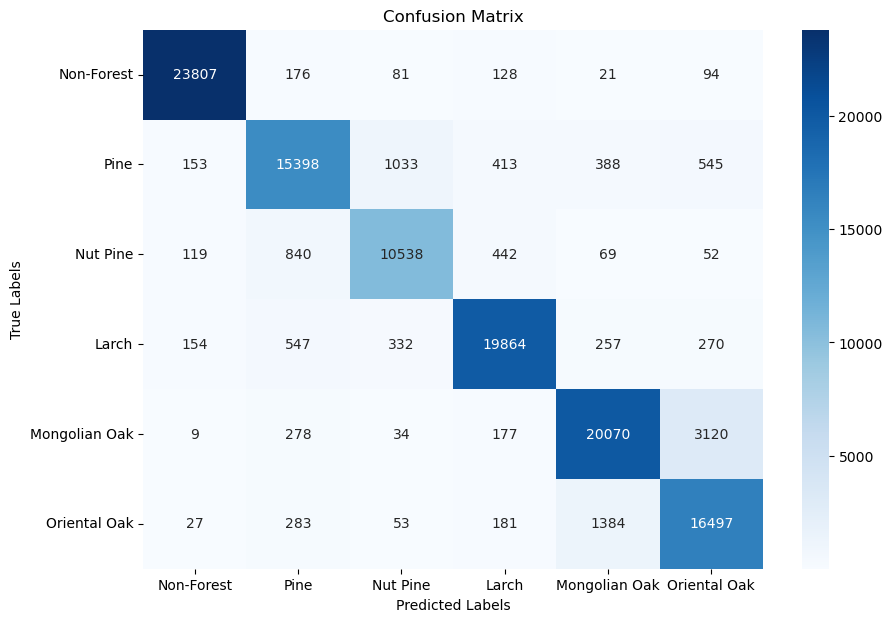

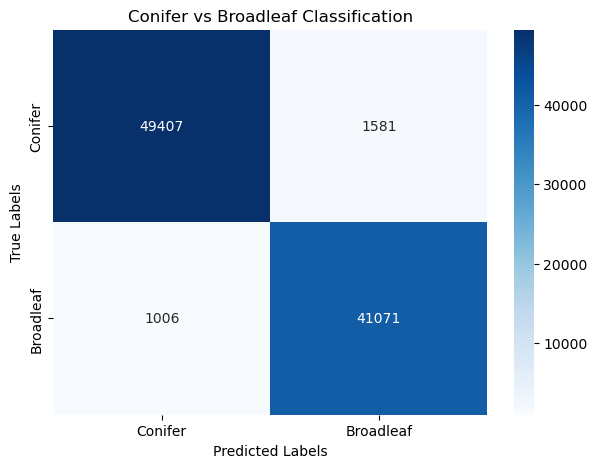

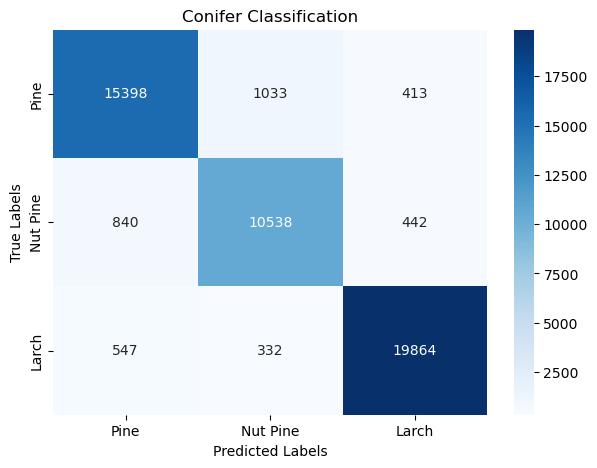

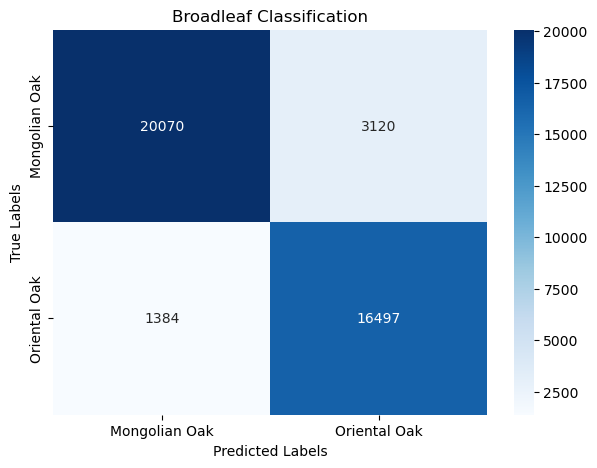

validation data


Evaluation Progress: 100%|██████████| 1163/1163 [00:05<00:00, 228.89it/s]


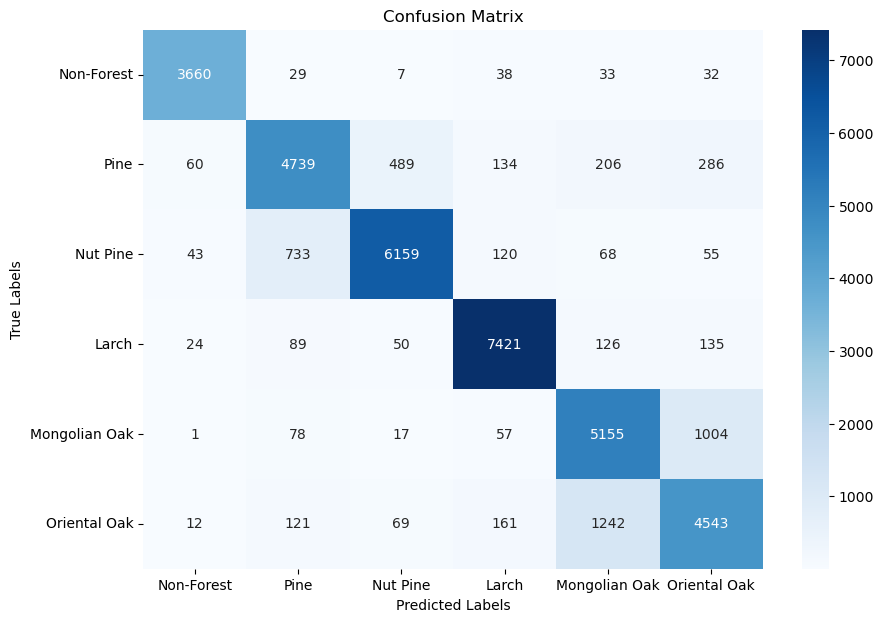

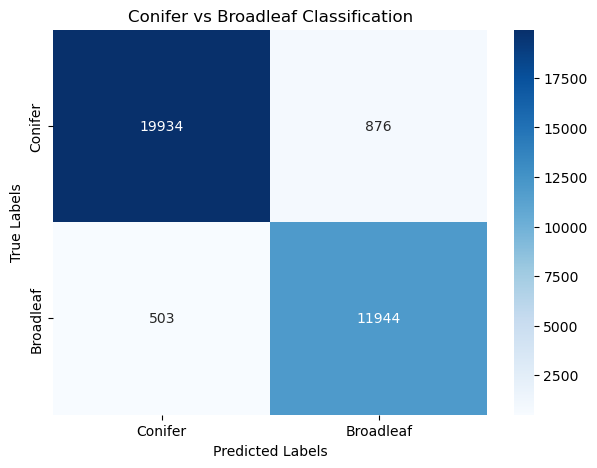

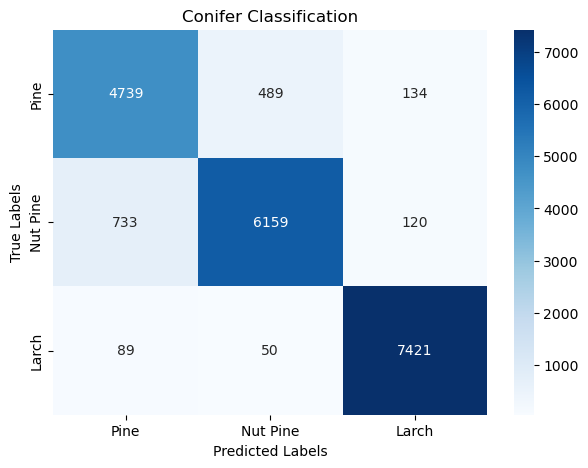

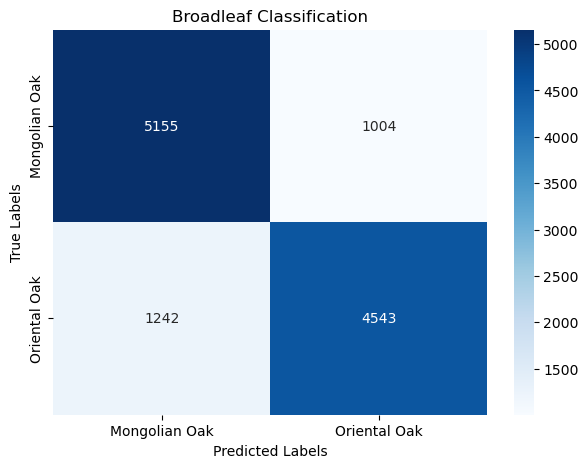

5
Training with patch size: 5


Epoch 1/50 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 227.19it/s]



Epoch [1/50], Train Loss: 0.5003, Train Accuracy: 81.37%, Val Loss: 0.4831, Val Accuracy: 82.49%



Epoch 2/50 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 228.20it/s]



Epoch [2/50], Train Loss: 0.3967, Train Accuracy: 85.25%, Val Loss: 0.4998, Val Accuracy: 84.06%



Epoch 3/50 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 227.13it/s]



Epoch [3/50], Train Loss: 0.3540, Train Accuracy: 87.05%, Val Loss: 0.4995, Val Accuracy: 83.44%



Epoch 4/50 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 228.17it/s]



Epoch [4/50], Train Loss: 0.3281, Train Accuracy: 87.92%, Val Loss: 0.4367, Val Accuracy: 85.62%



Epoch 5/50 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 226.60it/s]



Epoch [5/50], Train Loss: 0.3095, Train Accuracy: 88.70%, Val Loss: 0.5026, Val Accuracy: 83.71%



Epoch 6/50 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 228.23it/s]



Epoch [6/50], Train Loss: 0.2959, Train Accuracy: 89.10%, Val Loss: 0.4305, Val Accuracy: 86.41%



Epoch 7/50 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 228.95it/s]



Epoch [7/50], Train Loss: 0.2822, Train Accuracy: 89.74%, Val Loss: 0.4305, Val Accuracy: 86.70%



Epoch 8/50 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 228.36it/s]



Epoch [8/50], Train Loss: 0.2734, Train Accuracy: 89.99%, Val Loss: 0.4223, Val Accuracy: 86.16%



Epoch 9/50 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 228.69it/s]



Epoch [9/50], Train Loss: 0.2653, Train Accuracy: 90.29%, Val Loss: 0.4147, Val Accuracy: 87.41%



Epoch 10/50 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 227.83it/s]



Epoch [10/50], Train Loss: 0.2576, Train Accuracy: 90.64%, Val Loss: 0.4198, Val Accuracy: 87.02%



Epoch 11/50 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 227.93it/s]



Epoch [11/50], Train Loss: 0.2495, Train Accuracy: 90.92%, Val Loss: 0.4561, Val Accuracy: 85.73%



Epoch 12/50 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 226.27it/s]



Epoch [12/50], Train Loss: 0.2458, Train Accuracy: 91.05%, Val Loss: 0.4821, Val Accuracy: 85.86%



Epoch 13/50 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 228.05it/s]



Epoch [13/50], Train Loss: 0.2384, Train Accuracy: 91.22%, Val Loss: 0.4751, Val Accuracy: 85.82%



Epoch 14/50 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 224.54it/s]



Epoch [14/50], Train Loss: 0.2359, Train Accuracy: 91.41%, Val Loss: 0.5410, Val Accuracy: 83.85%



Epoch 15/50 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 225.93it/s]



Epoch [15/50], Train Loss: 0.2297, Train Accuracy: 91.59%, Val Loss: 0.4419, Val Accuracy: 86.77%



Epoch 16/50 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 226.82it/s]



Epoch [16/50], Train Loss: 0.2260, Train Accuracy: 91.69%, Val Loss: 0.4587, Val Accuracy: 86.95%



Epoch 17/50 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 224.17it/s]



Epoch [17/50], Train Loss: 0.2202, Train Accuracy: 91.95%, Val Loss: 0.4371, Val Accuracy: 86.67%



Epoch 18/50 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 226.00it/s]



Epoch [18/50], Train Loss: 0.2154, Train Accuracy: 92.07%, Val Loss: 0.4640, Val Accuracy: 86.89%



Epoch 19/50 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 228.64it/s]



Epoch [19/50], Train Loss: 0.2140, Train Accuracy: 92.14%, Val Loss: 0.5232, Val Accuracy: 84.22%



Epoch 20/50 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 225.54it/s]



Epoch [20/50], Train Loss: 0.2105, Train Accuracy: 92.29%, Val Loss: 0.4671, Val Accuracy: 86.50%



Epoch 21/50 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 229.14it/s]



Epoch [21/50], Train Loss: 0.2075, Train Accuracy: 92.44%, Val Loss: 0.5011, Val Accuracy: 84.64%



Epoch 22/50 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 228.78it/s]



Epoch [22/50], Train Loss: 0.2056, Train Accuracy: 92.49%, Val Loss: 0.5123, Val Accuracy: 85.98%



Epoch 23/50 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 226.00it/s]



Epoch [23/50], Train Loss: 0.2008, Train Accuracy: 92.67%, Val Loss: 0.4646, Val Accuracy: 86.26%



Epoch 24/50 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 228.64it/s]



Epoch [24/50], Train Loss: 0.2009, Train Accuracy: 92.64%, Val Loss: 0.4719, Val Accuracy: 86.59%



Epoch 25/50 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 223.93it/s]



Epoch [25/50], Train Loss: 0.1971, Train Accuracy: 92.77%, Val Loss: 0.4884, Val Accuracy: 86.54%



Epoch 26/50 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 227.13it/s]



Epoch [26/50], Train Loss: 0.1946, Train Accuracy: 92.94%, Val Loss: 0.4447, Val Accuracy: 87.33%



Epoch 27/50 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 226.37it/s]



Epoch [27/50], Train Loss: 0.1925, Train Accuracy: 92.93%, Val Loss: 0.5496, Val Accuracy: 85.07%



Epoch 28/50 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 227.27it/s]



Epoch [28/50], Train Loss: 0.1898, Train Accuracy: 93.00%, Val Loss: 0.5118, Val Accuracy: 85.73%



Epoch 29/50 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 226.08it/s]



Epoch [29/50], Train Loss: 0.1884, Train Accuracy: 93.07%, Val Loss: 0.5508, Val Accuracy: 85.23%



Epoch 30/50 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 227.41it/s]



Epoch [30/50], Train Loss: 0.1863, Train Accuracy: 93.21%, Val Loss: 0.4667, Val Accuracy: 86.79%



Epoch 31/50 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 227.59it/s]



Epoch [31/50], Train Loss: 0.1837, Train Accuracy: 93.24%, Val Loss: 0.4936, Val Accuracy: 85.52%



Epoch 32/50 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 227.42it/s]



Epoch [32/50], Train Loss: 0.1824, Train Accuracy: 93.32%, Val Loss: 0.5009, Val Accuracy: 86.44%



Epoch 33/50 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 227.63it/s]



Epoch [33/50], Train Loss: 0.1811, Train Accuracy: 93.36%, Val Loss: 0.5066, Val Accuracy: 86.22%



Epoch 34/50 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 224.57it/s]



Epoch [34/50], Train Loss: 0.1784, Train Accuracy: 93.56%, Val Loss: 0.4394, Val Accuracy: 88.14%



Epoch 35/50 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 227.92it/s]



Epoch [35/50], Train Loss: 0.1753, Train Accuracy: 93.58%, Val Loss: 0.5868, Val Accuracy: 84.40%



Epoch 36/50 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 225.02it/s]



Epoch [36/50], Train Loss: 0.1723, Train Accuracy: 93.66%, Val Loss: 0.4726, Val Accuracy: 87.63%



Epoch 37/50 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 227.49it/s]



Epoch [37/50], Train Loss: 0.1744, Train Accuracy: 93.64%, Val Loss: 0.4931, Val Accuracy: 86.15%



Epoch 38/50 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 224.60it/s]



Epoch [38/50], Train Loss: 0.1721, Train Accuracy: 93.74%, Val Loss: 0.5571, Val Accuracy: 83.67%



Epoch 39/50 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 227.58it/s]



Epoch [39/50], Train Loss: 0.1684, Train Accuracy: 93.80%, Val Loss: 0.4995, Val Accuracy: 87.06%



Epoch 40/50 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 224.13it/s]



Epoch [40/50], Train Loss: 0.1694, Train Accuracy: 93.81%, Val Loss: 0.5299, Val Accuracy: 86.62%



Epoch 41/50 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 227.99it/s]



Epoch [41/50], Train Loss: 0.1660, Train Accuracy: 93.92%, Val Loss: 0.5304, Val Accuracy: 85.24%



Epoch 42/50 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 224.02it/s]



Epoch [42/50], Train Loss: 0.1646, Train Accuracy: 94.04%, Val Loss: 0.4572, Val Accuracy: 86.94%



Epoch 43/50 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 227.57it/s]



Epoch [43/50], Train Loss: 0.1680, Train Accuracy: 93.83%, Val Loss: 0.5360, Val Accuracy: 85.18%



Epoch 44/50 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 226.45it/s]



Epoch [44/50], Train Loss: 0.1631, Train Accuracy: 94.02%, Val Loss: 0.4920, Val Accuracy: 87.13%



Epoch 45/50 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 227.92it/s]



Epoch [45/50], Train Loss: 0.1631, Train Accuracy: 94.01%, Val Loss: 0.4969, Val Accuracy: 87.20%



Epoch 46/50 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 226.43it/s]



Epoch [46/50], Train Loss: 0.1618, Train Accuracy: 94.01%, Val Loss: 0.4898, Val Accuracy: 87.15%



Epoch 47/50 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 228.31it/s]



Epoch [47/50], Train Loss: 0.1589, Train Accuracy: 94.19%, Val Loss: 0.5301, Val Accuracy: 86.30%



Epoch 48/50 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 226.65it/s]



Epoch [48/50], Train Loss: 0.1593, Train Accuracy: 94.19%, Val Loss: 0.6005, Val Accuracy: 81.45%



Epoch 49/50 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 228.31it/s]



Epoch [49/50], Train Loss: 0.1561, Train Accuracy: 94.35%, Val Loss: 0.5317, Val Accuracy: 85.94%



Epoch 50/50 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 226.45it/s]



Epoch [50/50], Train Loss: 0.1560, Train Accuracy: 94.28%, Val Loss: 0.5170, Val Accuracy: 86.16%

train data


Evaluation Progress: 100%|██████████| 3662/3662 [00:16<00:00, 226.96it/s]


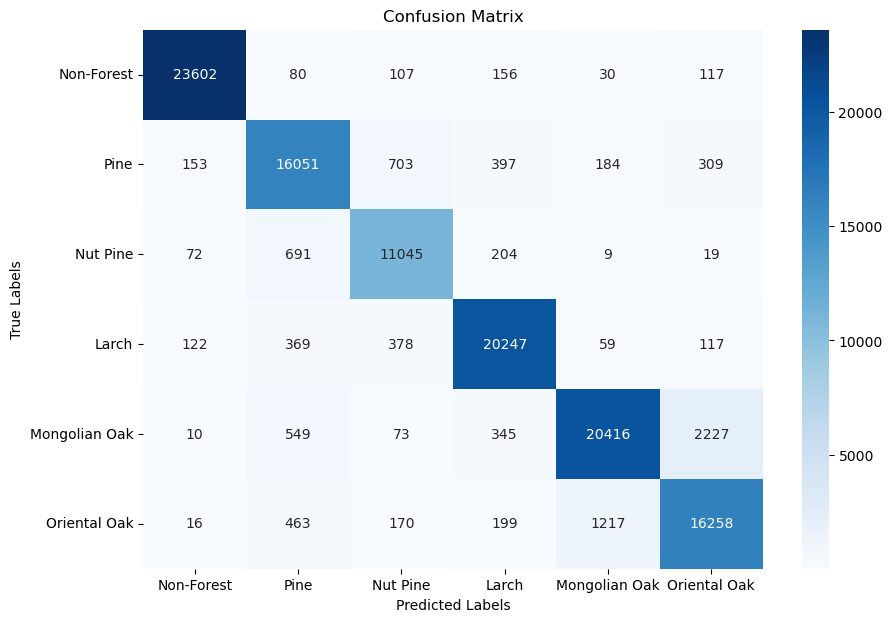

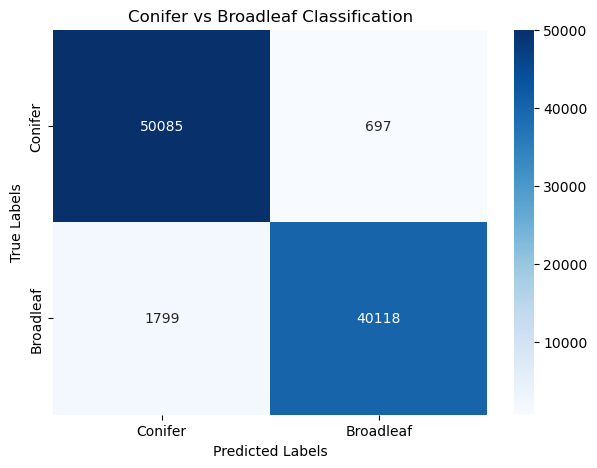

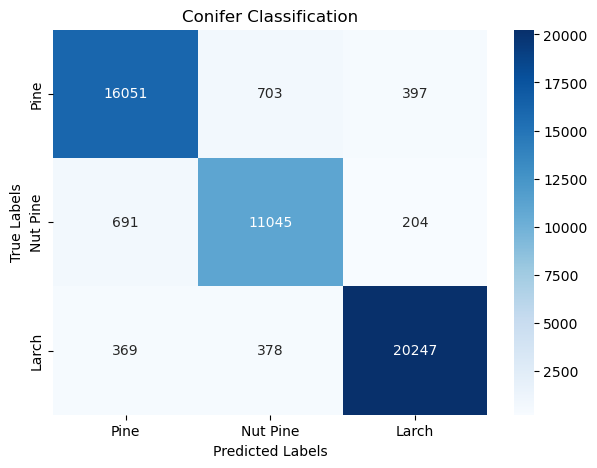

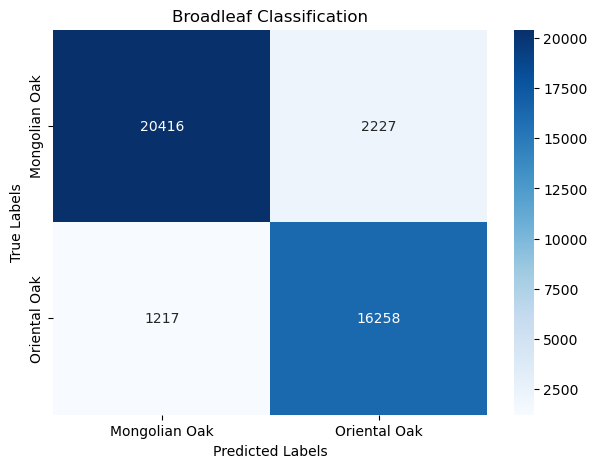

validation data


Evaluation Progress: 100%|██████████| 1159/1159 [00:05<00:00, 227.62it/s]


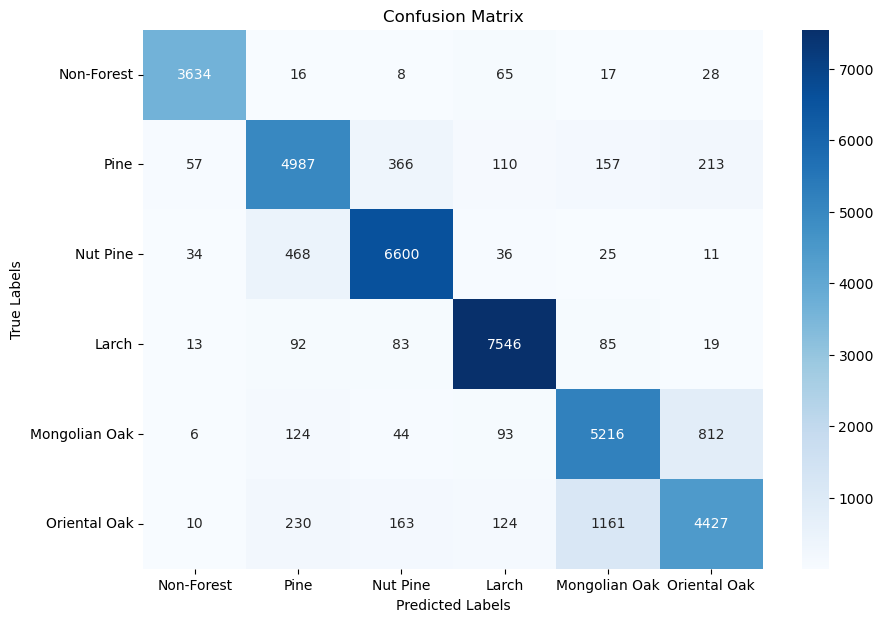

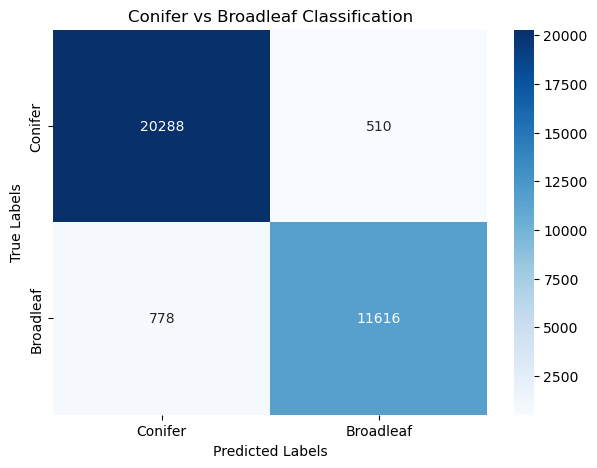

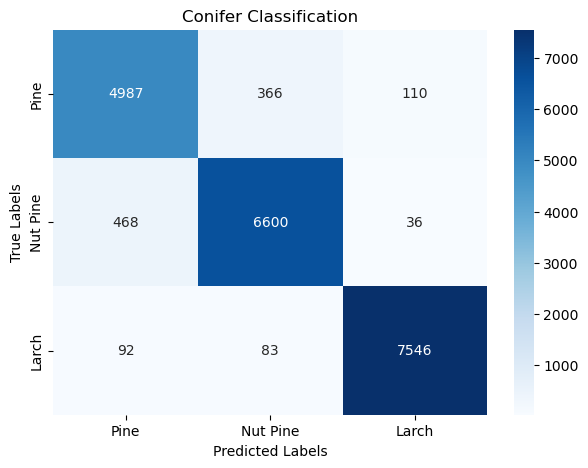

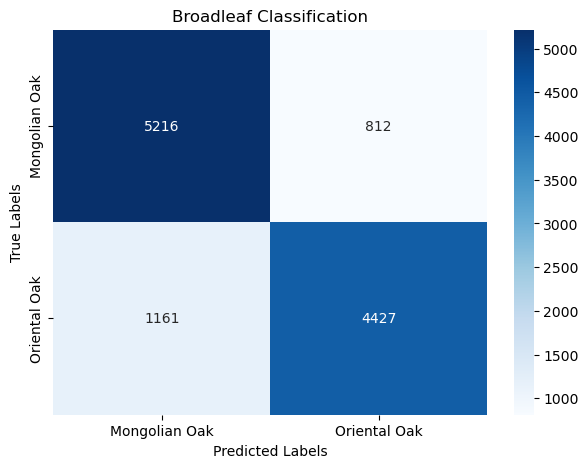

7
Training with patch size: 7


Epoch 1/50 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 222.40it/s]



Epoch [1/50], Train Loss: 0.4815, Train Accuracy: 82.13%, Val Loss: 0.4679, Val Accuracy: 84.58%



Epoch 2/50 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 222.56it/s]



Epoch [2/50], Train Loss: 0.3771, Train Accuracy: 85.93%, Val Loss: 0.4339, Val Accuracy: 85.57%



Epoch 3/50 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 222.59it/s]



Epoch [3/50], Train Loss: 0.3381, Train Accuracy: 87.58%, Val Loss: 0.4508, Val Accuracy: 84.61%



Epoch 4/50 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 222.52it/s]



Epoch [4/50], Train Loss: 0.3108, Train Accuracy: 88.64%, Val Loss: 0.4530, Val Accuracy: 86.01%



Epoch 5/50 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 222.47it/s]



Epoch [5/50], Train Loss: 0.2922, Train Accuracy: 89.35%, Val Loss: 0.4842, Val Accuracy: 85.02%



Epoch 6/50 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 223.06it/s]



Epoch [6/50], Train Loss: 0.2755, Train Accuracy: 89.92%, Val Loss: 0.5558, Val Accuracy: 78.42%



Epoch 7/50 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 221.72it/s]



Epoch [7/50], Train Loss: 0.2635, Train Accuracy: 90.40%, Val Loss: 0.4472, Val Accuracy: 86.42%



Epoch 8/50 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 221.57it/s]



Epoch [8/50], Train Loss: 0.2544, Train Accuracy: 90.71%, Val Loss: 0.3988, Val Accuracy: 87.89%



Epoch 9/50 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 219.25it/s]



Epoch [9/50], Train Loss: 0.2459, Train Accuracy: 91.03%, Val Loss: 0.4637, Val Accuracy: 86.65%



Epoch 10/50 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 222.74it/s]



Epoch [10/50], Train Loss: 0.2370, Train Accuracy: 91.32%, Val Loss: 0.5121, Val Accuracy: 85.89%



Epoch 11/50 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 220.45it/s]



Epoch [11/50], Train Loss: 0.2300, Train Accuracy: 91.60%, Val Loss: 0.5075, Val Accuracy: 84.31%



Epoch 12/50 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 222.87it/s]



Epoch [12/50], Train Loss: 0.2239, Train Accuracy: 91.82%, Val Loss: 0.5025, Val Accuracy: 84.48%



Epoch 13/50 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 222.67it/s]



Epoch [13/50], Train Loss: 0.2195, Train Accuracy: 92.02%, Val Loss: 0.4706, Val Accuracy: 86.97%



Epoch 14/50 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 221.15it/s]



Epoch [14/50], Train Loss: 0.2145, Train Accuracy: 92.23%, Val Loss: 0.4712, Val Accuracy: 87.04%



Epoch 15/50 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 222.69it/s]



Epoch [15/50], Train Loss: 0.2094, Train Accuracy: 92.44%, Val Loss: 0.4971, Val Accuracy: 86.42%



Epoch 16/50 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 220.26it/s]



Epoch [16/50], Train Loss: 0.2053, Train Accuracy: 92.47%, Val Loss: 0.5076, Val Accuracy: 84.82%



Epoch 17/50 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 222.90it/s]



Epoch [17/50], Train Loss: 0.2027, Train Accuracy: 92.61%, Val Loss: 0.4402, Val Accuracy: 87.31%



Epoch 18/50 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 221.67it/s]



Epoch [18/50], Train Loss: 0.1976, Train Accuracy: 92.73%, Val Loss: 0.4339, Val Accuracy: 86.84%



Epoch 19/50 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 218.67it/s]



Epoch [19/50], Train Loss: 0.1950, Train Accuracy: 92.94%, Val Loss: 0.4527, Val Accuracy: 86.97%



Epoch 20/50 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 219.40it/s]



Epoch [20/50], Train Loss: 0.1929, Train Accuracy: 93.01%, Val Loss: 0.4610, Val Accuracy: 87.11%



Epoch 21/50 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 223.10it/s]



Epoch [21/50], Train Loss: 0.1899, Train Accuracy: 93.11%, Val Loss: 0.4289, Val Accuracy: 88.02%



Epoch 22/50 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 222.55it/s]



Epoch [22/50], Train Loss: 0.1873, Train Accuracy: 93.22%, Val Loss: 0.4539, Val Accuracy: 86.77%



Epoch 23/50 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 223.01it/s]



Epoch [23/50], Train Loss: 0.1832, Train Accuracy: 93.38%, Val Loss: 0.4751, Val Accuracy: 86.57%



Epoch 24/50 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 223.10it/s]



Epoch [24/50], Train Loss: 0.1809, Train Accuracy: 93.35%, Val Loss: 0.4654, Val Accuracy: 87.37%



Epoch 25/50 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 223.02it/s]



Epoch [25/50], Train Loss: 0.1807, Train Accuracy: 93.41%, Val Loss: 0.4756, Val Accuracy: 86.03%



Epoch 26/50 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 223.02it/s]



Epoch [26/50], Train Loss: 0.1776, Train Accuracy: 93.53%, Val Loss: 0.4546, Val Accuracy: 87.85%



Epoch 27/50 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 222.38it/s]



Epoch [27/50], Train Loss: 0.1735, Train Accuracy: 93.69%, Val Loss: 0.6165, Val Accuracy: 81.77%



Epoch 28/50 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 221.46it/s]



Epoch [28/50], Train Loss: 0.1716, Train Accuracy: 93.71%, Val Loss: 0.4833, Val Accuracy: 87.54%



Epoch 29/50 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 219.05it/s]



Epoch [29/50], Train Loss: 0.1697, Train Accuracy: 93.85%, Val Loss: 0.4846, Val Accuracy: 86.55%



Epoch 30/50 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 219.51it/s]



Epoch [30/50], Train Loss: 0.1678, Train Accuracy: 93.86%, Val Loss: 0.4839, Val Accuracy: 87.16%



Epoch 31/50 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 222.97it/s]



Epoch [31/50], Train Loss: 0.1656, Train Accuracy: 93.96%, Val Loss: 0.4852, Val Accuracy: 87.25%



Epoch 32/50 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 222.88it/s]



Epoch [32/50], Train Loss: 0.1631, Train Accuracy: 94.03%, Val Loss: 0.5092, Val Accuracy: 86.59%



Epoch 33/50 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 223.06it/s]



Epoch [33/50], Train Loss: 0.1632, Train Accuracy: 94.03%, Val Loss: 0.5705, Val Accuracy: 85.53%



Epoch 34/50 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 222.97it/s]



Epoch [34/50], Train Loss: 0.1617, Train Accuracy: 94.14%, Val Loss: 0.4953, Val Accuracy: 86.21%



Epoch 35/50 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 222.66it/s]



Epoch [35/50], Train Loss: 0.1574, Train Accuracy: 94.26%, Val Loss: 0.5650, Val Accuracy: 85.63%



Epoch 36/50 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 222.81it/s]



Epoch [36/50], Train Loss: 0.1565, Train Accuracy: 94.30%, Val Loss: 0.5832, Val Accuracy: 84.77%



Epoch 37/50 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 222.92it/s]



Epoch [37/50], Train Loss: 0.1545, Train Accuracy: 94.37%, Val Loss: 0.5395, Val Accuracy: 86.00%



Epoch 38/50 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 221.80it/s]



Epoch [38/50], Train Loss: 0.1561, Train Accuracy: 94.26%, Val Loss: 0.5568, Val Accuracy: 85.79%



Epoch 39/50 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 221.55it/s]



Epoch [39/50], Train Loss: 0.1558, Train Accuracy: 94.37%, Val Loss: 0.5332, Val Accuracy: 86.23%



Epoch 40/50 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 219.71it/s]



Epoch [40/50], Train Loss: 0.1510, Train Accuracy: 94.45%, Val Loss: 0.4932, Val Accuracy: 87.47%



Epoch 41/50 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 222.97it/s]



Epoch [41/50], Train Loss: 0.1487, Train Accuracy: 94.60%, Val Loss: 0.5325, Val Accuracy: 86.37%



Epoch 42/50 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 222.20it/s]



Epoch [42/50], Train Loss: 0.1481, Train Accuracy: 94.58%, Val Loss: 0.5554, Val Accuracy: 86.57%



Epoch 43/50 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 223.05it/s]



Epoch [43/50], Train Loss: 0.1503, Train Accuracy: 94.53%, Val Loss: 0.5029, Val Accuracy: 86.73%



Epoch 44/50 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 222.80it/s]



Epoch [44/50], Train Loss: 0.1469, Train Accuracy: 94.67%, Val Loss: 0.5131, Val Accuracy: 86.73%



Epoch 45/50 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 222.76it/s]



Epoch [45/50], Train Loss: 0.1456, Train Accuracy: 94.73%, Val Loss: 0.5332, Val Accuracy: 85.64%



Epoch 46/50 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 222.48it/s]



Epoch [46/50], Train Loss: 0.1423, Train Accuracy: 94.82%, Val Loss: 0.4909, Val Accuracy: 87.21%



Epoch 47/50 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 221.70it/s]



Epoch [47/50], Train Loss: 0.1437, Train Accuracy: 94.80%, Val Loss: 0.5008, Val Accuracy: 86.91%



Epoch 48/50 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 219.65it/s]



Epoch [48/50], Train Loss: 0.1405, Train Accuracy: 94.85%, Val Loss: 0.5741, Val Accuracy: 84.90%



Epoch 49/50 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 219.83it/s]



Epoch [49/50], Train Loss: 0.1404, Train Accuracy: 94.85%, Val Loss: 0.5861, Val Accuracy: 84.94%



Epoch 50/50 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 223.05it/s]



Epoch [50/50], Train Loss: 0.1417, Train Accuracy: 94.81%, Val Loss: 0.5016, Val Accuracy: 86.94%

train data


Evaluation Progress: 100%|██████████| 3662/3662 [00:16<00:00, 221.46it/s]


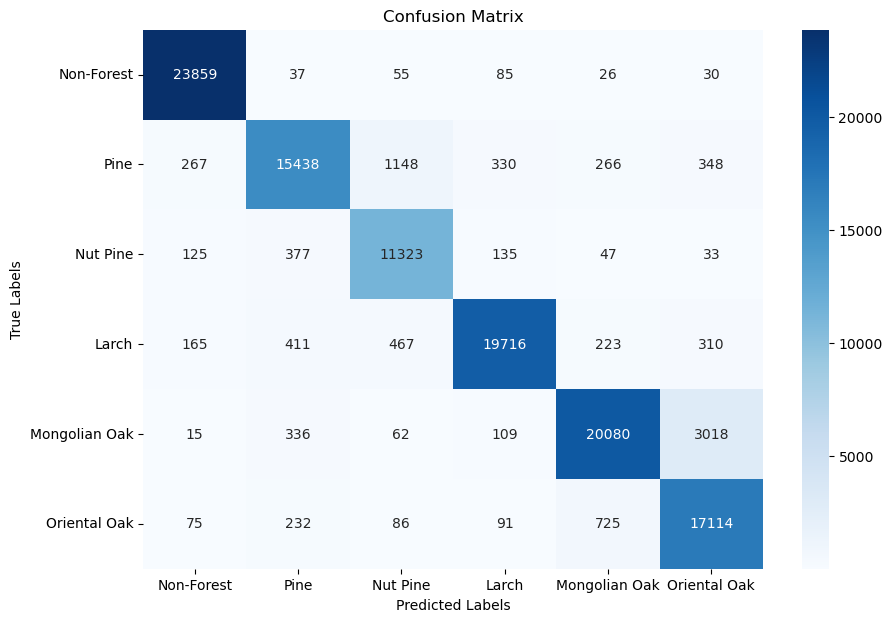

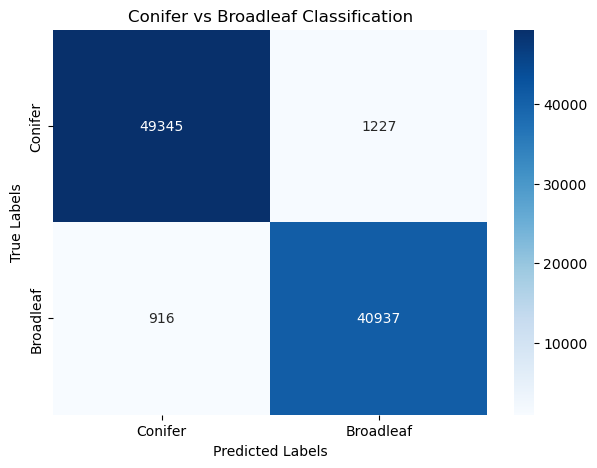

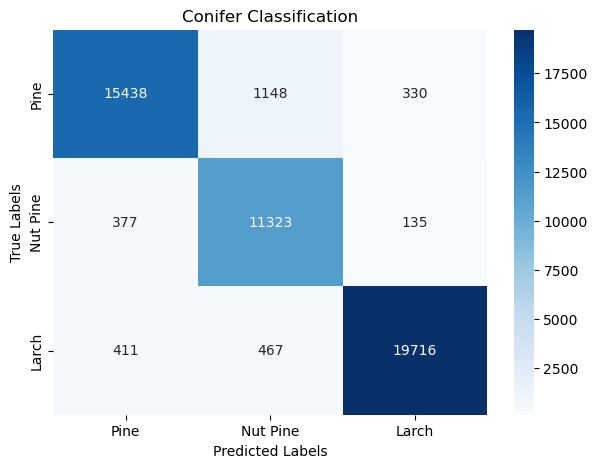

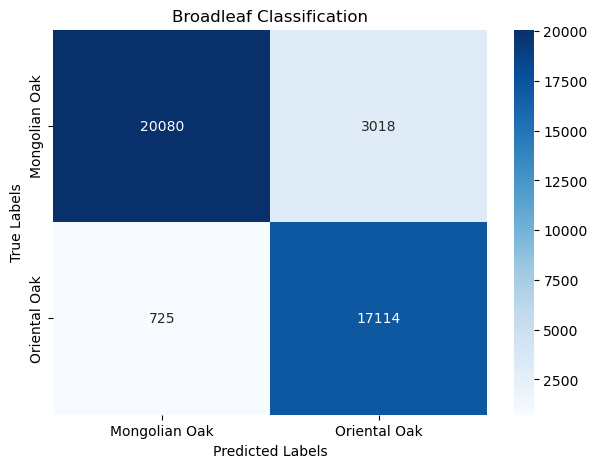

validation data


Evaluation Progress: 100%|██████████| 1159/1159 [00:05<00:00, 219.84it/s]


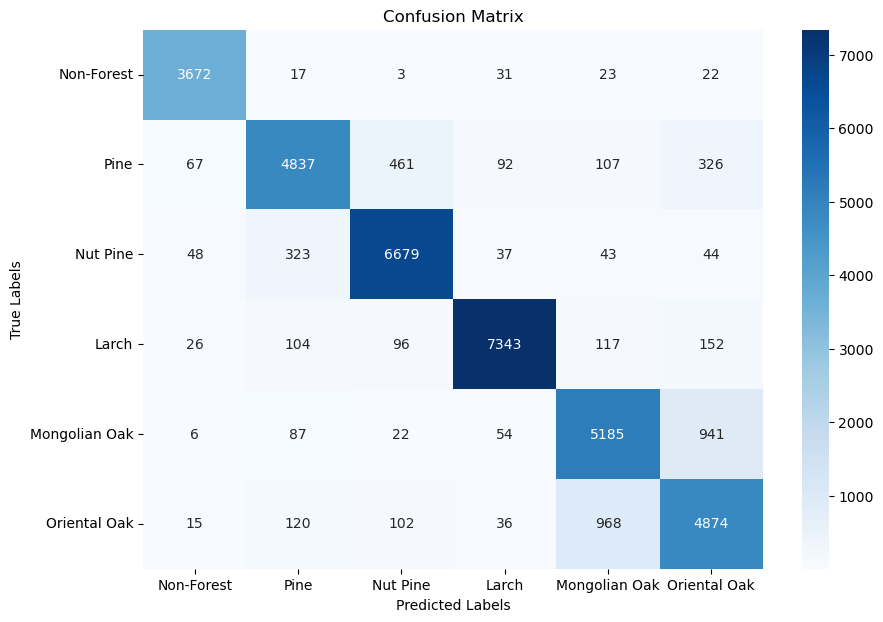

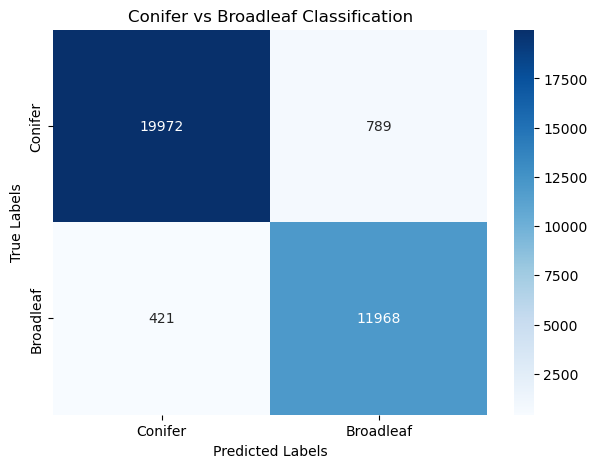

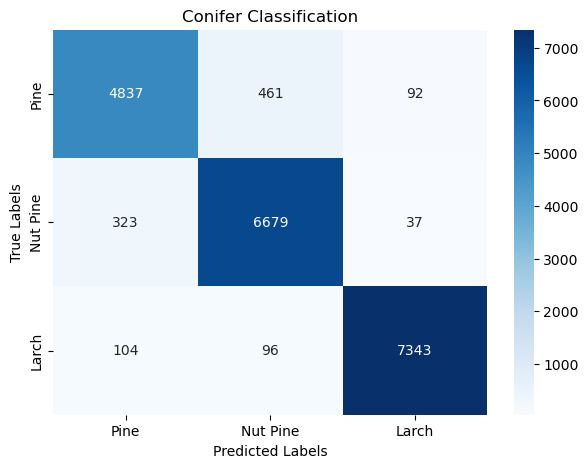

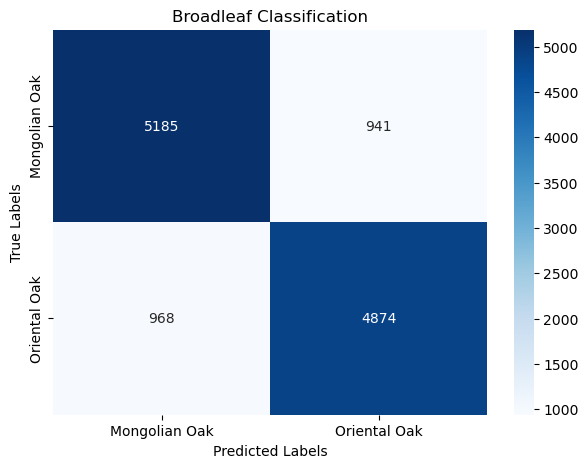

9
Training with patch size: 9


Epoch 1/50 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 212.27it/s]



Epoch [1/50], Train Loss: 0.4771, Train Accuracy: 82.36%, Val Loss: 0.4655, Val Accuracy: 83.63%



Epoch 2/50 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 212.45it/s]



Epoch [2/50], Train Loss: 0.3703, Train Accuracy: 86.34%, Val Loss: 0.4272, Val Accuracy: 85.91%



Epoch 3/50 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 212.13it/s]



Epoch [3/50], Train Loss: 0.3277, Train Accuracy: 88.10%, Val Loss: 0.3868, Val Accuracy: 87.47%



Epoch 4/50 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 211.47it/s]



Epoch [4/50], Train Loss: 0.3010, Train Accuracy: 88.99%, Val Loss: 0.4771, Val Accuracy: 85.49%



Epoch 5/50 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 213.04it/s]



Epoch [5/50], Train Loss: 0.2808, Train Accuracy: 89.78%, Val Loss: 0.3866, Val Accuracy: 88.54%



Epoch 6/50 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 213.21it/s]



Epoch [6/50], Train Loss: 0.2639, Train Accuracy: 90.35%, Val Loss: 0.4095, Val Accuracy: 87.41%



Epoch 7/50 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 211.58it/s]



Epoch [7/50], Train Loss: 0.2538, Train Accuracy: 90.81%, Val Loss: 0.5983, Val Accuracy: 81.28%



Epoch 8/50 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 212.03it/s]



Epoch [8/50], Train Loss: 0.2422, Train Accuracy: 91.21%, Val Loss: 0.4953, Val Accuracy: 85.95%



Epoch 9/50 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 213.12it/s]



Epoch [9/50], Train Loss: 0.2335, Train Accuracy: 91.53%, Val Loss: 0.4458, Val Accuracy: 86.90%



Epoch 10/50 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 212.87it/s]



Epoch [10/50], Train Loss: 0.2262, Train Accuracy: 91.81%, Val Loss: 0.4313, Val Accuracy: 87.66%



Epoch 11/50 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 212.50it/s]



Epoch [11/50], Train Loss: 0.2176, Train Accuracy: 92.04%, Val Loss: 0.4721, Val Accuracy: 85.89%



Epoch 12/50 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 209.91it/s]



Epoch [12/50], Train Loss: 0.2145, Train Accuracy: 92.21%, Val Loss: 0.4586, Val Accuracy: 87.20%



Epoch 13/50 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 210.20it/s]



Epoch [13/50], Train Loss: 0.2087, Train Accuracy: 92.38%, Val Loss: 0.4830, Val Accuracy: 86.69%



Epoch 14/50 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 213.35it/s]



Epoch [14/50], Train Loss: 0.2035, Train Accuracy: 92.60%, Val Loss: 0.4735, Val Accuracy: 85.77%



Epoch 15/50 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 213.06it/s]



Epoch [15/50], Train Loss: 0.1970, Train Accuracy: 92.87%, Val Loss: 0.4862, Val Accuracy: 86.48%



Epoch 16/50 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 211.92it/s]



Epoch [16/50], Train Loss: 0.1943, Train Accuracy: 92.92%, Val Loss: 0.4783, Val Accuracy: 86.76%



Epoch 17/50 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 209.70it/s]



Epoch [17/50], Train Loss: 0.1916, Train Accuracy: 93.05%, Val Loss: 0.4861, Val Accuracy: 86.21%



Epoch 18/50 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 213.28it/s]



Epoch [18/50], Train Loss: 0.1851, Train Accuracy: 93.28%, Val Loss: 0.4457, Val Accuracy: 87.86%



Epoch 19/50 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 212.95it/s]



Epoch [19/50], Train Loss: 0.1842, Train Accuracy: 93.34%, Val Loss: 0.4755, Val Accuracy: 86.98%



Epoch 20/50 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 213.20it/s]



Epoch [20/50], Train Loss: 0.1795, Train Accuracy: 93.52%, Val Loss: 0.4293, Val Accuracy: 88.00%



Epoch 21/50 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 210.14it/s]



Epoch [21/50], Train Loss: 0.1775, Train Accuracy: 93.52%, Val Loss: 0.5038, Val Accuracy: 87.04%



Epoch 22/50 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 211.86it/s]



Epoch [22/50], Train Loss: 0.1751, Train Accuracy: 93.67%, Val Loss: 0.5748, Val Accuracy: 83.98%



Epoch 23/50 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 211.46it/s]



Epoch [23/50], Train Loss: 0.1719, Train Accuracy: 93.74%, Val Loss: 0.4892, Val Accuracy: 87.21%



Epoch 24/50 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 213.09it/s]



Epoch [24/50], Train Loss: 0.1687, Train Accuracy: 93.91%, Val Loss: 0.4445, Val Accuracy: 87.38%



Epoch 25/50 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 210.65it/s]



Epoch [25/50], Train Loss: 0.1659, Train Accuracy: 93.92%, Val Loss: 0.5668, Val Accuracy: 85.46%



Epoch 26/50 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 212.08it/s]



Epoch [26/50], Train Loss: 0.1648, Train Accuracy: 93.90%, Val Loss: 0.5161, Val Accuracy: 87.29%



Epoch 27/50 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 211.50it/s]



Epoch [27/50], Train Loss: 0.1636, Train Accuracy: 94.06%, Val Loss: 0.5636, Val Accuracy: 86.51%



Epoch 28/50 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 213.25it/s]



Epoch [28/50], Train Loss: 0.1609, Train Accuracy: 94.14%, Val Loss: 0.4923, Val Accuracy: 87.66%



Epoch 29/50 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 212.99it/s]



Epoch [29/50], Train Loss: 0.1569, Train Accuracy: 94.32%, Val Loss: 0.5019, Val Accuracy: 86.93%



Epoch 30/50 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 213.06it/s]



Epoch [30/50], Train Loss: 0.1559, Train Accuracy: 94.30%, Val Loss: 0.4792, Val Accuracy: 87.83%



Epoch 31/50 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 211.82it/s]



Epoch [31/50], Train Loss: 0.1529, Train Accuracy: 94.38%, Val Loss: 0.5405, Val Accuracy: 86.54%



Epoch 32/50 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 210.80it/s]



Epoch [32/50], Train Loss: 0.1521, Train Accuracy: 94.44%, Val Loss: 0.5527, Val Accuracy: 86.72%



Epoch 33/50 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 211.98it/s]



Epoch [33/50], Train Loss: 0.1519, Train Accuracy: 94.47%, Val Loss: 0.4644, Val Accuracy: 87.30%



Epoch 34/50 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 210.73it/s]



Epoch [34/50], Train Loss: 0.1477, Train Accuracy: 94.66%, Val Loss: 0.5284, Val Accuracy: 87.27%



Epoch 35/50 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 212.54it/s]



Epoch [35/50], Train Loss: 0.1474, Train Accuracy: 94.67%, Val Loss: 0.5049, Val Accuracy: 87.50%



Epoch 36/50 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 212.64it/s]



Epoch [36/50], Train Loss: 0.1469, Train Accuracy: 94.64%, Val Loss: 0.5310, Val Accuracy: 86.85%



Epoch 37/50 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 210.27it/s]



Epoch [37/50], Train Loss: 0.1436, Train Accuracy: 94.76%, Val Loss: 0.4896, Val Accuracy: 86.21%



Epoch 38/50 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 209.23it/s]



Epoch [38/50], Train Loss: 0.1434, Train Accuracy: 94.79%, Val Loss: 0.5524, Val Accuracy: 86.77%



Epoch 39/50 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 211.48it/s]



Epoch [39/50], Train Loss: 0.1403, Train Accuracy: 94.94%, Val Loss: 0.5345, Val Accuracy: 87.01%



Epoch 40/50 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 212.73it/s]



Epoch [40/50], Train Loss: 0.1387, Train Accuracy: 94.95%, Val Loss: 0.4926, Val Accuracy: 87.74%



Epoch 41/50 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 213.09it/s]



Epoch [41/50], Train Loss: 0.1368, Train Accuracy: 95.00%, Val Loss: 0.5526, Val Accuracy: 86.93%



Epoch 42/50 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 211.99it/s]



Epoch [42/50], Train Loss: 0.1379, Train Accuracy: 95.09%, Val Loss: 0.4900, Val Accuracy: 87.23%



Epoch 43/50 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 209.92it/s]



Epoch [43/50], Train Loss: 0.1357, Train Accuracy: 95.06%, Val Loss: 0.5586, Val Accuracy: 86.72%



Epoch 44/50 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 212.16it/s]



Epoch [44/50], Train Loss: 0.1352, Train Accuracy: 95.14%, Val Loss: 0.5143, Val Accuracy: 87.60%



Epoch 45/50 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 213.01it/s]



Epoch [45/50], Train Loss: 0.1344, Train Accuracy: 95.07%, Val Loss: 0.5212, Val Accuracy: 86.85%



Epoch 46/50 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 211.45it/s]



Epoch [46/50], Train Loss: 0.1315, Train Accuracy: 95.22%, Val Loss: 0.5234, Val Accuracy: 87.18%



Epoch 47/50 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 211.33it/s]



Epoch [47/50], Train Loss: 0.1311, Train Accuracy: 95.22%, Val Loss: 0.5166, Val Accuracy: 87.38%



Epoch 48/50 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 212.71it/s]



Epoch [48/50], Train Loss: 0.1282, Train Accuracy: 95.35%, Val Loss: 0.5197, Val Accuracy: 87.40%



Epoch 49/50 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 212.22it/s]



Epoch [49/50], Train Loss: 0.1275, Train Accuracy: 95.38%, Val Loss: 0.5263, Val Accuracy: 86.97%



Epoch 50/50 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 210.25it/s]



Epoch [50/50], Train Loss: 0.1269, Train Accuracy: 95.39%, Val Loss: 0.5480, Val Accuracy: 86.31%

train data


Evaluation Progress: 100%|██████████| 3662/3662 [00:17<00:00, 211.23it/s]


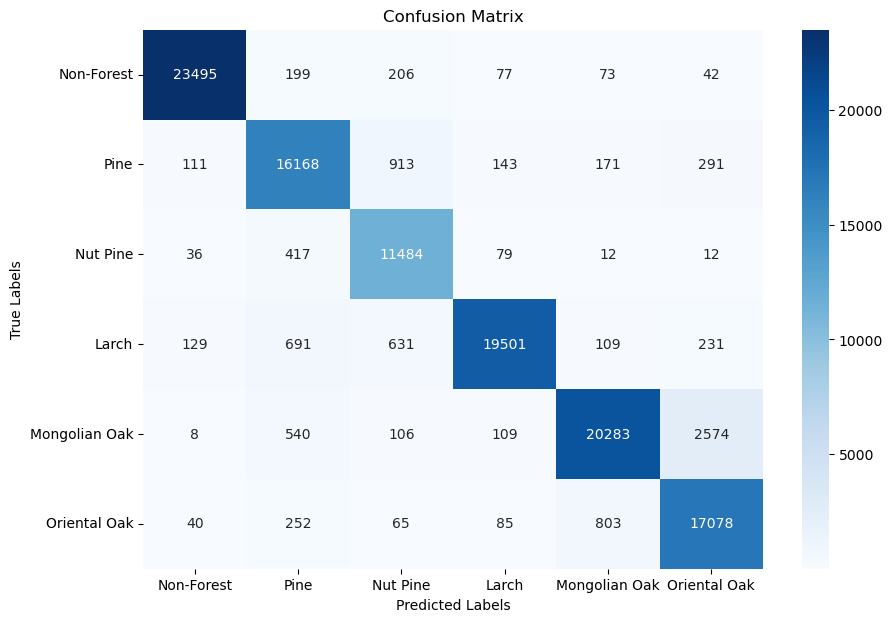

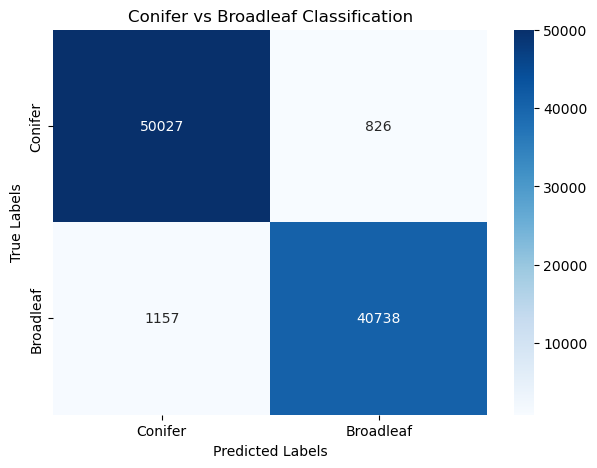

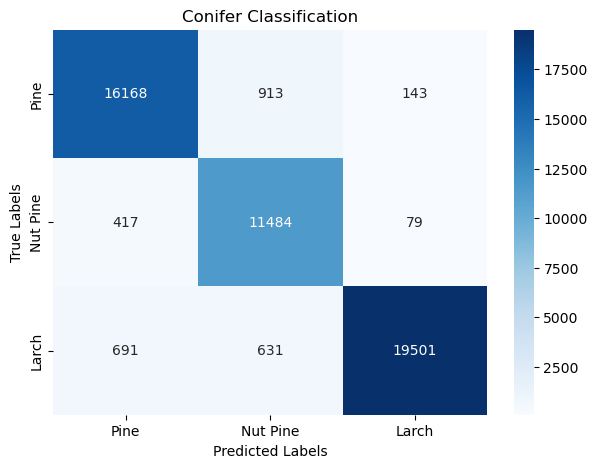

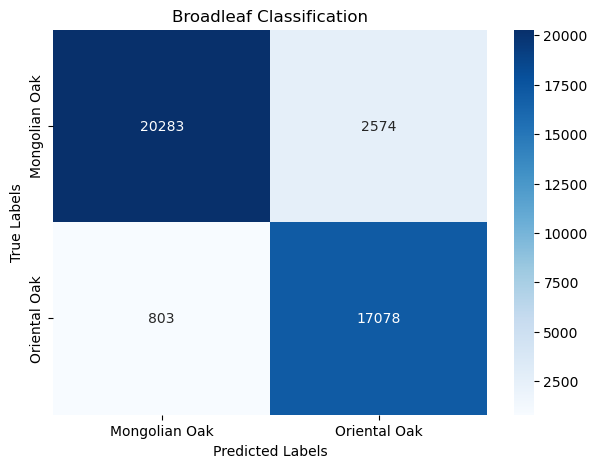

validation data


Evaluation Progress: 100%|██████████| 1159/1159 [00:05<00:00, 210.79it/s]


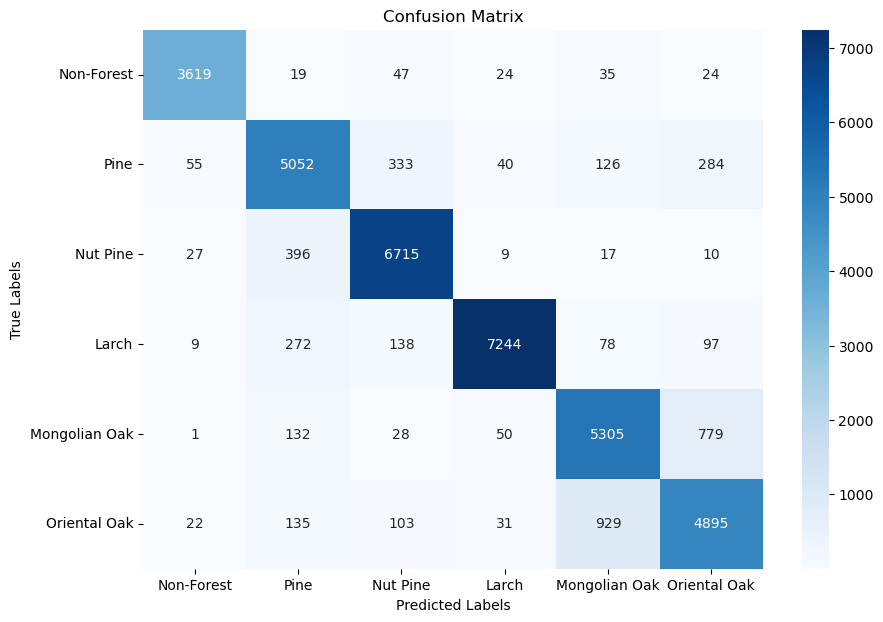

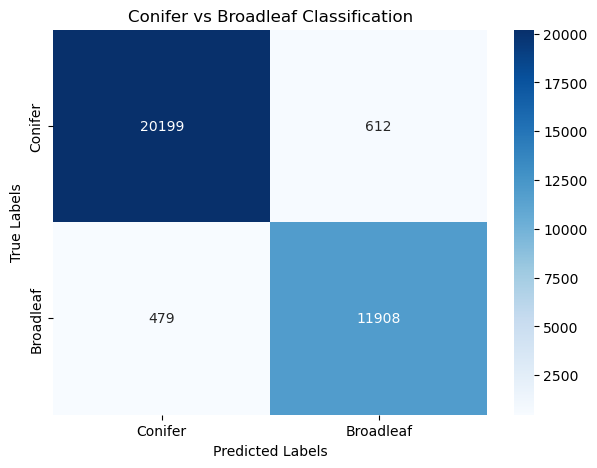

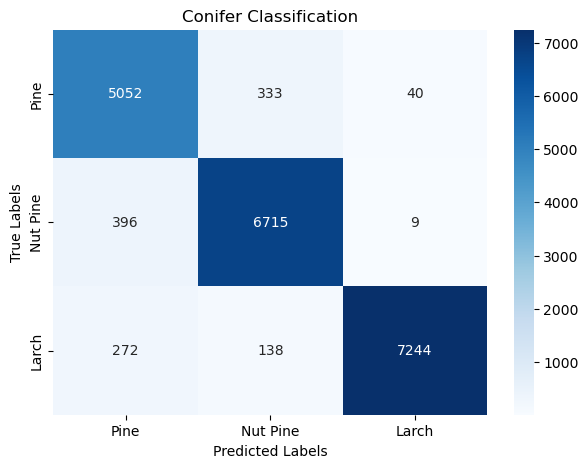

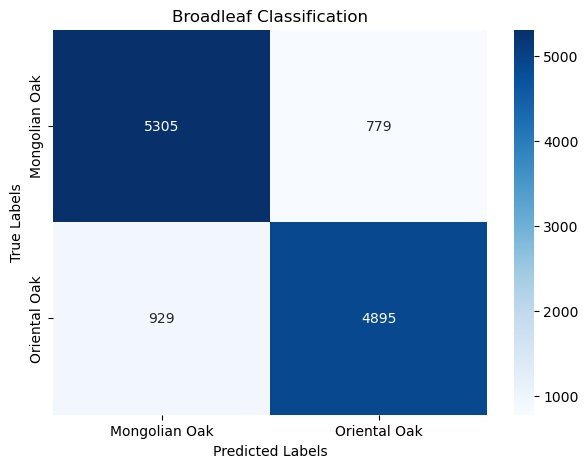

11
Training with patch size: 11


Epoch 1/50 - Validation: 100%|██████████| 1155/1155 [00:05<00:00, 202.93it/s]



Epoch [1/50], Train Loss: 0.4697, Train Accuracy: 82.50%, Val Loss: 0.4649, Val Accuracy: 82.97%



Epoch 2/50 - Validation: 100%|██████████| 1155/1155 [00:05<00:00, 202.26it/s]



Epoch [2/50], Train Loss: 0.3600, Train Accuracy: 86.87%, Val Loss: 0.5541, Val Accuracy: 80.61%



Epoch 3/50 - Validation: 100%|██████████| 1155/1155 [00:05<00:00, 203.27it/s]



Epoch [3/50], Train Loss: 0.3158, Train Accuracy: 88.45%, Val Loss: 0.4354, Val Accuracy: 86.53%



Epoch 4/50 - Validation: 100%|██████████| 1155/1155 [00:05<00:00, 202.89it/s]



Epoch [4/50], Train Loss: 0.2876, Train Accuracy: 89.49%, Val Loss: 0.4327, Val Accuracy: 85.98%



Epoch 5/50 - Validation: 100%|██████████| 1155/1155 [00:05<00:00, 202.64it/s]



Epoch [5/50], Train Loss: 0.2686, Train Accuracy: 90.34%, Val Loss: 0.4208, Val Accuracy: 87.77%



Epoch 6/50 - Validation: 100%|██████████| 1155/1155 [00:05<00:00, 202.27it/s]



Epoch [6/50], Train Loss: 0.2521, Train Accuracy: 90.93%, Val Loss: 0.4409, Val Accuracy: 86.80%



Epoch 7/50 - Validation: 100%|██████████| 1155/1155 [00:05<00:00, 203.33it/s]



Epoch [7/50], Train Loss: 0.2404, Train Accuracy: 91.32%, Val Loss: 0.4013, Val Accuracy: 87.57%



Epoch 8/50 - Validation: 100%|██████████| 1155/1155 [00:05<00:00, 202.51it/s]



Epoch [8/50], Train Loss: 0.2293, Train Accuracy: 91.79%, Val Loss: 0.4155, Val Accuracy: 87.99%



Epoch 9/50 - Validation: 100%|██████████| 1155/1155 [00:05<00:00, 203.63it/s]



Epoch [9/50], Train Loss: 0.2214, Train Accuracy: 92.07%, Val Loss: 0.4560, Val Accuracy: 86.27%



Epoch 10/50 - Validation: 100%|██████████| 1155/1155 [00:05<00:00, 202.70it/s]



Epoch [10/50], Train Loss: 0.2135, Train Accuracy: 92.44%, Val Loss: 0.4441, Val Accuracy: 86.91%



Epoch 11/50 - Validation: 100%|██████████| 1155/1155 [00:05<00:00, 203.13it/s]



Epoch [11/50], Train Loss: 0.2057, Train Accuracy: 92.61%, Val Loss: 0.4025, Val Accuracy: 88.62%



Epoch 12/50 - Validation: 100%|██████████| 1155/1155 [00:05<00:00, 202.51it/s]



Epoch [12/50], Train Loss: 0.1984, Train Accuracy: 92.87%, Val Loss: 0.4694, Val Accuracy: 87.01%



Epoch 13/50 - Validation: 100%|██████████| 1155/1155 [00:05<00:00, 201.05it/s]



Epoch [13/50], Train Loss: 0.1932, Train Accuracy: 93.11%, Val Loss: 0.4747, Val Accuracy: 86.49%



Epoch 14/50 - Validation: 100%|██████████| 1155/1155 [00:05<00:00, 202.09it/s]



Epoch [14/50], Train Loss: 0.1893, Train Accuracy: 93.18%, Val Loss: 0.4970, Val Accuracy: 87.37%



Epoch 15/50 - Validation: 100%|██████████| 1155/1155 [00:05<00:00, 201.64it/s]



Epoch [15/50], Train Loss: 0.1859, Train Accuracy: 93.20%, Val Loss: 0.4560, Val Accuracy: 87.77%



Epoch 16/50 - Validation: 100%|██████████| 1155/1155 [00:05<00:00, 202.38it/s]



Epoch [16/50], Train Loss: 0.1814, Train Accuracy: 93.41%, Val Loss: 0.4437, Val Accuracy: 87.16%



Epoch 17/50 - Validation: 100%|██████████| 1155/1155 [00:05<00:00, 201.21it/s]



Epoch [17/50], Train Loss: 0.1780, Train Accuracy: 93.59%, Val Loss: 0.5095, Val Accuracy: 86.87%



Epoch 18/50 - Validation: 100%|██████████| 1155/1155 [00:05<00:00, 202.97it/s]



Epoch [18/50], Train Loss: 0.1721, Train Accuracy: 93.80%, Val Loss: 0.4893, Val Accuracy: 86.94%



Epoch 19/50 - Validation: 100%|██████████| 1155/1155 [00:05<00:00, 200.68it/s]



Epoch [19/50], Train Loss: 0.1708, Train Accuracy: 93.92%, Val Loss: 0.4120, Val Accuracy: 88.64%



Epoch 20/50 - Validation: 100%|██████████| 1155/1155 [00:05<00:00, 203.65it/s]



Epoch [20/50], Train Loss: 0.1696, Train Accuracy: 93.91%, Val Loss: 0.4496, Val Accuracy: 88.16%



Epoch 21/50 - Validation: 100%|██████████| 1155/1155 [00:05<00:00, 200.84it/s]



Epoch [21/50], Train Loss: 0.1645, Train Accuracy: 94.10%, Val Loss: 0.4690, Val Accuracy: 87.78%



Epoch 22/50 - Validation: 100%|██████████| 1155/1155 [00:05<00:00, 202.02it/s]



Epoch [22/50], Train Loss: 0.1595, Train Accuracy: 94.28%, Val Loss: 0.4619, Val Accuracy: 88.22%



Epoch 23/50 - Validation: 100%|██████████| 1155/1155 [00:05<00:00, 202.91it/s]



Epoch [23/50], Train Loss: 0.1592, Train Accuracy: 94.30%, Val Loss: 0.4977, Val Accuracy: 86.73%



Epoch 24/50 - Validation: 100%|██████████| 1155/1155 [00:05<00:00, 201.92it/s]



Epoch [24/50], Train Loss: 0.1549, Train Accuracy: 94.34%, Val Loss: 0.5508, Val Accuracy: 86.78%



Epoch 25/50 - Validation: 100%|██████████| 1155/1155 [00:05<00:00, 202.10it/s]



Epoch [25/50], Train Loss: 0.1520, Train Accuracy: 94.57%, Val Loss: 0.4818, Val Accuracy: 86.55%



Epoch 26/50 - Validation: 100%|██████████| 1155/1155 [00:05<00:00, 201.47it/s]



Epoch [26/50], Train Loss: 0.1509, Train Accuracy: 94.52%, Val Loss: 0.5023, Val Accuracy: 87.57%



Epoch 27/50 - Validation: 100%|██████████| 1155/1155 [00:05<00:00, 202.82it/s]



Epoch [27/50], Train Loss: 0.1496, Train Accuracy: 94.60%, Val Loss: 0.4904, Val Accuracy: 87.85%



Epoch 28/50 - Validation: 100%|██████████| 1155/1155 [00:05<00:00, 201.02it/s]



Epoch [28/50], Train Loss: 0.1465, Train Accuracy: 94.78%, Val Loss: 0.5027, Val Accuracy: 86.77%



Epoch 29/50 - Validation: 100%|██████████| 1155/1155 [00:05<00:00, 202.57it/s]



Epoch [29/50], Train Loss: 0.1442, Train Accuracy: 94.84%, Val Loss: 0.4830, Val Accuracy: 87.83%



Epoch 30/50 - Validation: 100%|██████████| 1155/1155 [00:05<00:00, 201.68it/s]



Epoch [30/50], Train Loss: 0.1419, Train Accuracy: 94.85%, Val Loss: 0.5777, Val Accuracy: 86.89%



Epoch 31/50 - Validation: 100%|██████████| 1155/1155 [00:05<00:00, 201.44it/s]



Epoch [31/50], Train Loss: 0.1404, Train Accuracy: 94.94%, Val Loss: 0.5647, Val Accuracy: 87.33%



Epoch 32/50 - Validation: 100%|██████████| 1155/1155 [00:05<00:00, 200.26it/s]



Epoch [32/50], Train Loss: 0.1402, Train Accuracy: 94.95%, Val Loss: 0.5065, Val Accuracy: 87.79%



Epoch 33/50 - Validation: 100%|██████████| 1155/1155 [00:05<00:00, 201.89it/s]



Epoch [33/50], Train Loss: 0.1396, Train Accuracy: 95.04%, Val Loss: 0.4698, Val Accuracy: 87.84%



Epoch 34/50 - Validation: 100%|██████████| 1155/1155 [00:05<00:00, 200.96it/s]



Epoch [34/50], Train Loss: 0.1366, Train Accuracy: 95.06%, Val Loss: 0.4821, Val Accuracy: 87.16%



Epoch 35/50 - Validation: 100%|██████████| 1155/1155 [00:05<00:00, 203.84it/s]



Epoch [35/50], Train Loss: 0.1334, Train Accuracy: 95.18%, Val Loss: 0.5054, Val Accuracy: 87.52%



Epoch 36/50 - Validation: 100%|██████████| 1155/1155 [00:05<00:00, 202.66it/s]



Epoch [36/50], Train Loss: 0.1325, Train Accuracy: 95.25%, Val Loss: 0.5270, Val Accuracy: 87.01%



Epoch 37/50 - Validation: 100%|██████████| 1155/1155 [00:05<00:00, 203.45it/s]



Epoch [37/50], Train Loss: 0.1321, Train Accuracy: 95.24%, Val Loss: 0.5203, Val Accuracy: 87.96%



Epoch 38/50 - Validation: 100%|██████████| 1155/1155 [00:05<00:00, 202.66it/s]



Epoch [38/50], Train Loss: 0.1295, Train Accuracy: 95.33%, Val Loss: 0.4722, Val Accuracy: 88.11%



Epoch 39/50 - Validation: 100%|██████████| 1155/1155 [00:05<00:00, 202.01it/s]



Epoch [39/50], Train Loss: 0.1266, Train Accuracy: 95.44%, Val Loss: 0.5198, Val Accuracy: 86.68%



Epoch 40/50 - Validation: 100%|██████████| 1155/1155 [00:05<00:00, 201.78it/s]



Epoch [40/50], Train Loss: 0.1282, Train Accuracy: 95.31%, Val Loss: 0.5181, Val Accuracy: 87.37%



Epoch 41/50 - Validation: 100%|██████████| 1155/1155 [00:05<00:00, 200.72it/s]



Epoch [41/50], Train Loss: 0.1260, Train Accuracy: 95.45%, Val Loss: 0.5366, Val Accuracy: 87.10%



Epoch 42/50 - Validation: 100%|██████████| 1155/1155 [00:05<00:00, 201.24it/s]



Epoch [42/50], Train Loss: 0.1254, Train Accuracy: 95.47%, Val Loss: 0.5404, Val Accuracy: 88.01%



Epoch 43/50 - Validation: 100%|██████████| 1155/1155 [00:05<00:00, 202.33it/s]



Epoch [43/50], Train Loss: 0.1234, Train Accuracy: 95.55%, Val Loss: 0.5182, Val Accuracy: 87.16%



Epoch 44/50 - Validation: 100%|██████████| 1155/1155 [00:05<00:00, 201.56it/s]



Epoch [44/50], Train Loss: 0.1213, Train Accuracy: 95.61%, Val Loss: 0.6032, Val Accuracy: 85.17%



Epoch 45/50 - Validation: 100%|██████████| 1155/1155 [00:05<00:00, 201.91it/s]



Epoch [45/50], Train Loss: 0.1196, Train Accuracy: 95.65%, Val Loss: 0.5353, Val Accuracy: 86.71%



Epoch 46/50 - Validation: 100%|██████████| 1155/1155 [00:05<00:00, 199.92it/s]



Epoch [46/50], Train Loss: 0.1192, Train Accuracy: 95.73%, Val Loss: 0.6310, Val Accuracy: 86.12%



Epoch 47/50 - Validation: 100%|██████████| 1155/1155 [00:05<00:00, 195.33it/s]



Epoch [47/50], Train Loss: 0.1194, Train Accuracy: 95.67%, Val Loss: 0.5544, Val Accuracy: 86.32%



Epoch 48/50 - Validation: 100%|██████████| 1155/1155 [00:05<00:00, 192.79it/s]



Epoch [48/50], Train Loss: 0.1155, Train Accuracy: 95.77%, Val Loss: 0.5844, Val Accuracy: 87.29%



Epoch 49/50 - Validation: 100%|██████████| 1155/1155 [00:05<00:00, 193.08it/s]



Epoch [49/50], Train Loss: 0.1155, Train Accuracy: 95.87%, Val Loss: 0.5125, Val Accuracy: 87.65%



Epoch 50/50 - Validation: 100%|██████████| 1155/1155 [00:06<00:00, 190.00it/s]



Epoch [50/50], Train Loss: 0.1145, Train Accuracy: 95.86%, Val Loss: 0.5704, Val Accuracy: 87.85%

train data


Evaluation Progress: 100%|██████████| 3640/3640 [00:18<00:00, 193.27it/s]


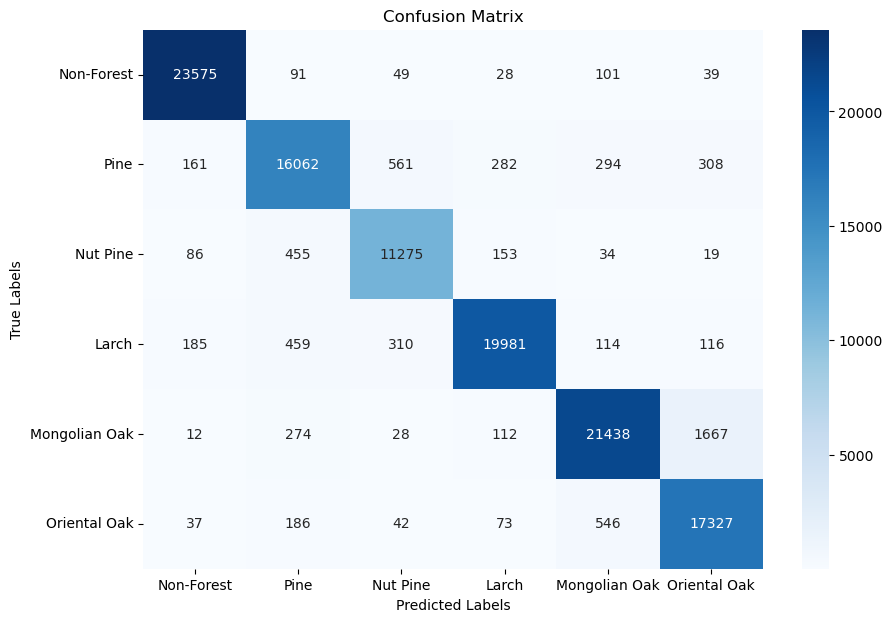

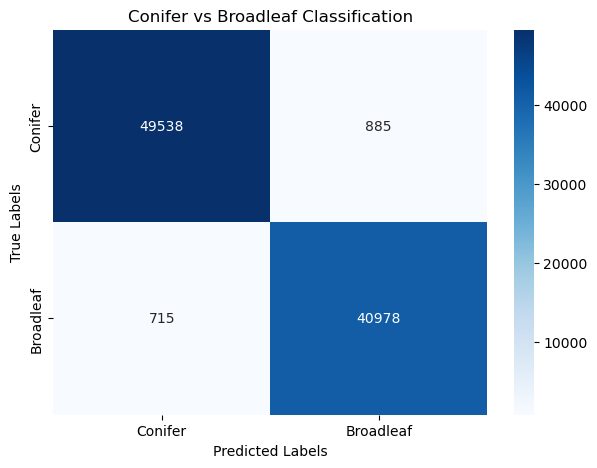

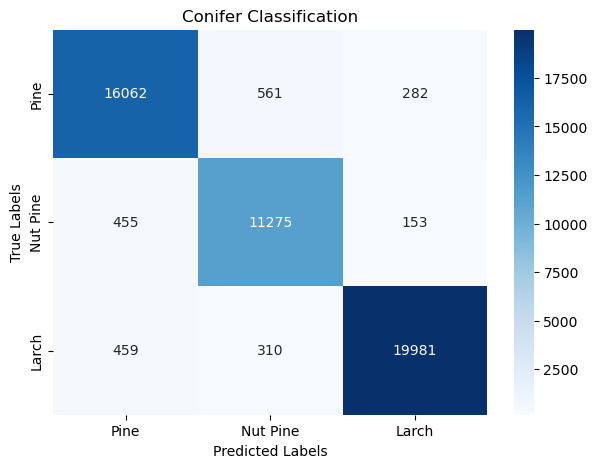

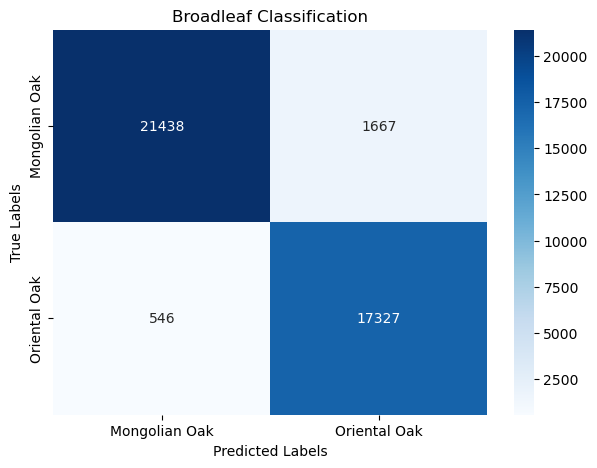

validation data


Evaluation Progress: 100%|██████████| 1155/1155 [00:05<00:00, 199.17it/s]


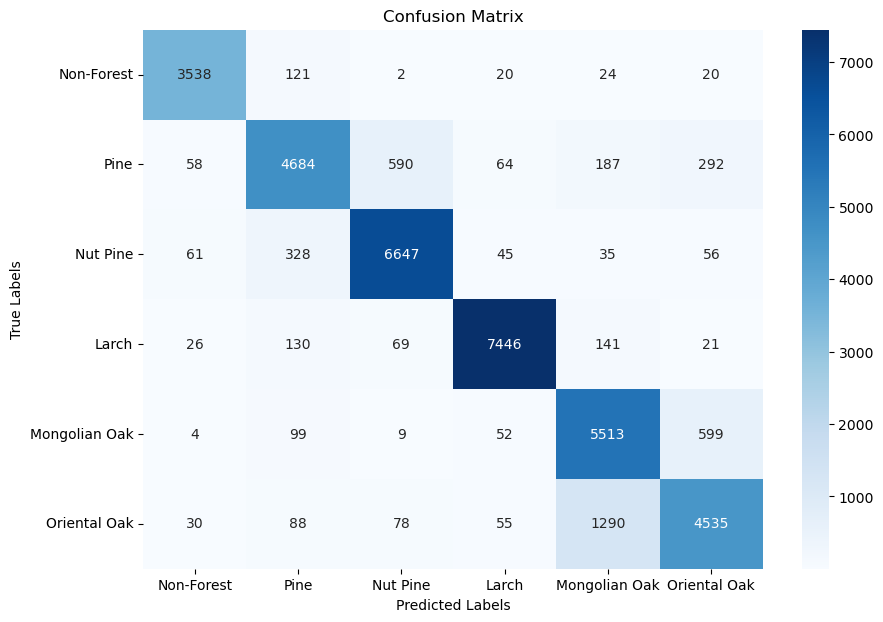

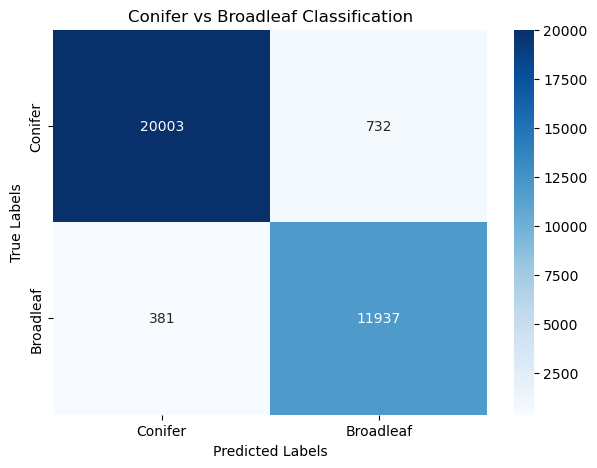

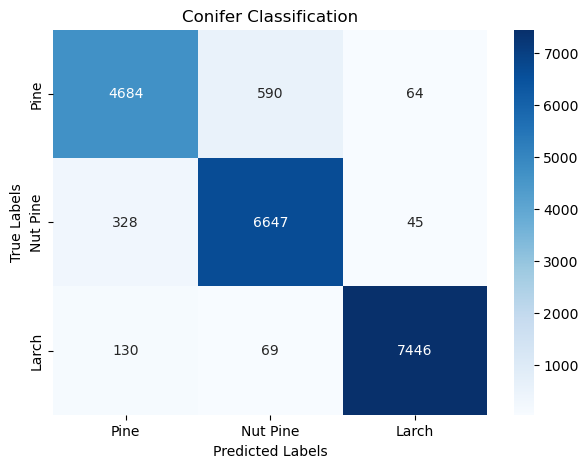

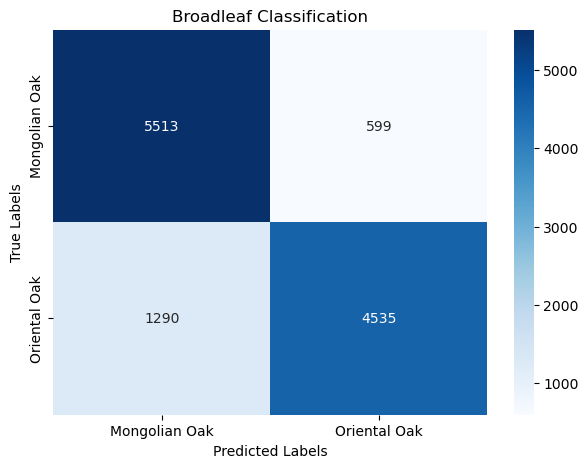

In [5]:
patch_sizes = [1, 3, 5, 7, 9, 11]
result_df_dicts = {"patch_size": [],
                   "data_type" : [],
                   "df" : []}

num_epochs = 50
os.makedirs("./checkpoints/patch_size_test", exist_ok=True) #checkpoints 저장할 dir

for patch_size in patch_sizes:
    print(patch_size)
    train_dataset, val_dataset = create_datasets(patch_size)
    train_loader, val_loader = create_dataloaders(train_dataset, val_dataset)
    
    print(f"Training with patch size: {patch_size}")

    model = ResNetLike(input_channels=48, num_classes=6).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    best_model_state, train_losses, val_losses = train_model(
        model, train_loader, val_loader, criterion, optimizer, num_epochs=num_epochs, patience=100
    )
    
    torch.save(best_model_state, f"./checkpoints/patch_size_test/ResNetLike_48_{patch_size}_{num_epochs}.pth")
    model.load_state_dict(best_model_state)
    
    print("train data")
    train_df = evaluate_model_with_cm(model, train_loader, num_classes=6)
    result_df_dicts["patch_size"].append(patch_size)
    result_df_dicts["data_type"].append("train_data")
    result_df_dicts["df"].append(train_df)
    
    print("validation data")
    validation_df = evaluate_model_with_cm(model, val_loader, num_classes=6)
    result_df_dicts["patch_size"].append(patch_size)
    result_df_dicts["data_type"].append("validation")
    result_df_dicts["df"].append(validation_df)

In [7]:
# 모든 데이터를 하나의 데이터프레임으로 합치기
final_df = pd.concat([
    df.assign(patch_size=patch, data_type=dt)
    for patch, dt, df in zip(result_df_dicts["patch_size"], result_df_dicts["data_type"], result_df_dicts["df"])
], ignore_index=False)

# 인덱스를 리셋하고 정리
final_df.reset_index(inplace=True)
final_df.rename(columns={"index": "class"}, inplace=True)

# 저장
os.makedirs("./results", exist_ok=True) 
final_df.to_csv("./results/patch_size_results.csv", index=False, encoding="utf-8-sig")